# TellCo — Due Diligence Data Analysis Notebook

**Purpose:** This notebook walks through a reproducible, reusable analysis pipeline for TellCo. It contains data preparation, exploratory data analysis (EDA), feature engineering, a feature store, a Streamlit dashboard, packaging scaffolding, and a report skeleton.

**How to use:** Place your dataset at `data/telcom_data.xlsx`  and run the cells top-to-bottom.

In [1]:
# Basic imports
import os
from pathlib import Path
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import logging
from logging.handlers import RotatingFileHandler
from openpyxl import load_workbook
from openpyxl.styles import Font, PatternFill, Alignment, Border, Side
from openpyxl.chart import BarChart, Reference
from openpyxl.utils import get_column_letter
import time, psutil, shutil
from scipy.spatial.distance import euclidean
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# For saving parquet
import pyarrow as pa
import pyarrow.parquet as pq

# Configure simple module logger for the notebook
logging.basicConfig(level=logging.INFO, format='%(asctime)s %(levelname)s %(message)s')
logger = logging.getLogger(__name__)
sns.set_style('whitegrid')


### Set paths (reading the data)

In [2]:
# Define base project path
BASE_DIR = Path.cwd()

DATA_DIR = BASE_DIR / "data"
OUTPUT_DIR = BASE_DIR / "output"
LOG_DIR = BASE_DIR / "logs"

INPUT_XLSX = DATA_DIR / "telcom_data.xlsx"
PARQUET_PATH = DATA_DIR / "cleaned_telecom_data.parquet"
OUTPUT_XLSX = OUTPUT_DIR / "telecom_data_analysis.xlsx"
LOG_FILE = LOG_DIR / "telecom_pipeline.log"


### Create directories if already not created

In [3]:
# Create directories if not present
OUTPUT_DIR.mkdir(exist_ok=True)
LOG_DIR.mkdir(exist_ok=True)

### Logging path setting and file naming
Here we are setting the log file path which will hold the logs for the entire pipeline of the project.

In [4]:
# -------------------------------------------------
# LOGGING CONFIGURATION FOR TELECOM PIPELINE
# -------------------------------------------------

# Create logs directory if it doesn't exist
LOG_DIR = "logs"
os.makedirs(LOG_DIR, exist_ok=True)

LOG_FILE = os.path.join(LOG_DIR, "telecom_pipeline.log")

# Remove any existing handlers (important for Jupyter)
for handler in logging.root.handlers[:]:
    logging.root.removeHandler(handler)

# Create logger
logger = logging.getLogger("telecom_pipeline")
logger.setLevel(logging.INFO)

# File handler (rotating to avoid huge files)
file_handler = RotatingFileHandler(
    LOG_FILE,
    maxBytes=5 * 1024 * 1024,  # 5 MB
    backupCount=3,
    encoding="utf-8"
)

# Console handler (optional but recommended)
console_handler = logging.StreamHandler()

# Log format
formatter = logging.Formatter(
    "%(asctime)s | %(levelname)s | %(name)s | %(message)s",
    datefmt="%Y-%m-%d %H:%M:%S"
)

file_handler.setFormatter(formatter)
console_handler.setFormatter(formatter)

# Attach handlers
logger.addHandler(file_handler)
logger.addHandler(console_handler)

logger.propagate = False

logger.info("Logging initialized successfully")


2025-12-22 12:38:44 | INFO | telecom_pipeline | Logging initialized successfully


### Load Raw Excel & Diagnose Header Issues

Telecom Excel files often have broken or shifted headers.

In [5]:
df_raw = pd.read_excel(INPUT_XLSX, sheet_name="Sheet1", header=None)
df_raw.head(10)


,0,1,2,3,4,5,6,7,8,9,...,45,46,47,48,49,50,51,52,53,54
0,Bearer Id,Start,Start ms,End,End ms,Dur. (ms),IMSI,MSISDN/Number,IMEI,Last Location Name,...,Youtube DL (Bytes),Youtube UL (Bytes),Netflix DL (Bytes),Netflix UL (Bytes),Gaming DL (Bytes),Gaming UL (Bytes),Other DL (Bytes),Other UL (Bytes),Total UL (Bytes),Total DL (Bytes)
1,13114483460844900352,2019-04-04 12:01:18,770,2019-04-25 14:35:31,662,1823652,208201448079117,33664962239,35521209507511,9164566995485190,...,15854611,2501332,8198936,9656251,278082303,14344150,171744450,8814393,36749741,308879636
2,13114483482878900224,2019-04-09 13:04:04,235,2019-04-25 08:15:48,606,1365104,208201909211140,33681854413,35794009006359,L77566A,...,20247395,19111729,18338413,17227132,608750074,1170709,526904238,15055145,53800391,653384965
3,13114483484080500736,2019-04-09 17:42:11,1,2019-04-25 11:58:13,652,1361762,208200314458056,33760627129,35281510359387,D42335A,...,19725661,14699576,17587794,6163408,229584621,395630,410692588,4215763,27883638,279807335
4,13114483485442799616,2019-04-10 00:31:25,486,2019-04-25 07:36:35,171,1321509,208201402342131,33750343200,35356610164913,T21824A,...,21388122,15146643,13994646,1097942,799538153,10849722,749039933,12797283,43324218,846028530
5,13114483499480700928,2019-04-12 20:10:23,565,2019-04-25 10:40:32,954,1089009,208201401415120,33699795932,35407009745539,D88865A,...,15259380,18962873,17124581,415218,527707248,3529801,550709500,13910322,38542814,569138589
6,13114483499779198976,2019-04-12 21:37:31,439,2019-04-25 08:08:09,553,1074638,208201402670191,33668185951,35298410295700,T89132C,...,21332918,2611113,7345361,6536448,710293538,13167974,654978277,4436057,30307754,754452212
7,13114483501243799552,2019-04-13 08:41:59,612,2019-04-25 08:16:21,168,1035261,208201448341047,33665368271,86762704322800,9164567010589190,...,7234465,1886295,13231006,17981760,44796223,14084934,803653557,10649768,47925246,70562047
8,13042425910865399808,2019-04-14 02:11:59,592,2019-04-25 02:26:52,512,951292,208201009069207,33763490140,86546404964017,CELL_208_20_520025_1,...,12189786,19735183,6858496,12075206,748906189,16149622,537601820,7714657,58813016,775350343
9,13114483506432499712,2019-04-14 12:48:32,121,2019-04-25 10:22:26,960,941634,208201448324028,33698743617,35562409696153,T42084A,...,18436641,10860867,10587264,8467177,821671285,6548349,172920486,14749031,42363146,861612261


### Load Excel with Correct Header

In [6]:
df = pd.read_excel(INPUT_XLSX, sheet_name="Sheet1", header=0)
logger.info("Excel data loaded with correct header row")

2025-12-22 12:42:32 | INFO | telecom_pipeline | Excel data loaded with correct header row


### High Level of information for the TellCo dataset
It will give a structural summary of the DataFrame — helping to quickly spot data quality issues before cleaning or modeling.

In [7]:
logger.info('DataFrame info displayed:')
df.info()

2025-12-22 12:42:32 | INFO | telecom_pipeline | DataFrame info displayed:


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150001 entries, 0 to 150000
Data columns (total 55 columns):
 #   Column                                    Non-Null Count   Dtype         
---  ------                                    --------------   -----         
 0   Bearer Id                                 150001 non-null  object        
 1   Start                                     150000 non-null  datetime64[ns]
 2   Start ms                                  150000 non-null  float64       
 3   End                                       150000 non-null  datetime64[ns]
 4   End ms                                    150000 non-null  float64       
 5   Dur. (ms)                                 150000 non-null  float64       
 6   IMSI                                      149431 non-null  float64       
 7   MSISDN/Number                             148935 non-null  float64       
 8   IMEI                                      149429 non-null  float64       
 9   Last Location N

### High level of overview of all columns/features
This will help to get a statistical summary of numeric columns in a DataFrame (here, `df_rounded`  means values were rounded earlier for readability)

In [8]:
df.describe()

,Start,Start ms,End,End ms,Dur. (ms),IMSI,MSISDN/Number,IMEI,Avg RTT DL (ms),Avg RTT UL (ms),...,Youtube DL (Bytes),Youtube UL (Bytes),Netflix DL (Bytes),Netflix UL (Bytes),Gaming DL (Bytes),Gaming UL (Bytes),Other DL (Bytes),Other UL (Bytes),Total UL (Bytes),Total DL (Bytes)
count,150000,150000.000000,150000,150000.000000,1.500000e+05,1.494310e+05,1.489350e+05,1.494290e+05,122172.000000,122189.000000,...,1.500010e+05,1.500010e+05,1.500010e+05,1.500010e+05,1.500010e+05,1.500010e+05,1.500010e+05,1.500010e+05,1.500000e+05,1.500000e+05
mean,2019-04-26 12:36:38.953740032,499.188200,2019-04-27 17:40:08.059673344,498.800880,1.046086e+05,2.082016e+14,4.188282e+10,4.847455e+13,109.795706,17.662883,...,1.163407e+07,1.100941e+07,1.162685e+07,1.100175e+07,4.220447e+08,8.288398e+06,4.211005e+08,8.264799e+06,4.112121e+07,4.546434e+08
min,2019-04-04 12:01:18,0.000000,2019-04-24 22:59:58,0.000000,7.142000e+03,2.040471e+14,3.360100e+10,4.400152e+11,0.000000,0.000000,...,5.300000e+01,1.050000e+02,4.200000e+01,3.500000e+01,2.516000e+03,5.900000e+01,3.290000e+03,1.480000e+02,2.866892e+06,7.114041e+06
25%,2019-04-25 00:26:00.750000128,250.000000,2019-04-26 07:30:11.500000,251.000000,5.744050e+04,2.082014e+14,3.365130e+10,3.546071e+13,32.000000,2.000000,...,5.833501e+06,5.517965e+06,5.777156e+06,5.475981e+06,2.104733e+08,4.128476e+06,2.101869e+08,4.145943e+06,3.322201e+07,2.431068e+08
50%,2019-04-26 08:51:24.500000,499.000000,2019-04-27 23:02:05,500.000000,8.639900e+04,2.082015e+14,3.366371e+10,3.572201e+13,45.000000,5.000000,...,1.161602e+07,1.101345e+07,1.164222e+07,1.099638e+07,4.234081e+08,8.291208e+06,4.218030e+08,8.267071e+06,4.114331e+07,4.558411e+08
75%,2019-04-27 18:18:59.750000128,749.000000,2019-04-29 07:15:07.500000,750.000000,1.324302e+05,2.082018e+14,3.368349e+10,8.611970e+13,70.000000,15.000000,...,1.744852e+07,1.651556e+07,1.747048e+07,1.650727e+07,6.331742e+08,1.243162e+07,6.316918e+08,1.238415e+07,4.903424e+07,6.657055e+08
max,2019-04-29 07:28:43,999.000000,2019-04-30 23:59:27,999.000000,1.859336e+06,2.140743e+14,8.823971e+14,9.900120e+13,96923.000000,7120.000000,...,2.325910e+07,2.201196e+07,2.325919e+07,2.201196e+07,8.434419e+08,1.655879e+07,8.434425e+08,1.655882e+07,7.833131e+07,9.029696e+08
std,NaN,288.611834,NaN,288.097653,8.103762e+04,2.148809e+10,2.447443e+12,2.241637e+13,619.782739,84.793524,...,6.710569e+06,6.345423e+06,6.725218e+06,6.359490e+06,2.439675e+08,4.782700e+06,2.432050e+08,4.769004e+06,1.127639e+07,2.441429e+08


### Shape
This lets us know the shape of the dataset before cleaning. It tells the total number of rows and columns present in the dataset.

In [9]:
df.shape

(150001, 55)

### Head
To understand the nature of the dataset we will find the first few rows data using `head()`. Usually by default it is top 5 rows that would be generated as a result of head().

In [10]:
df.head()

,Bearer Id,Start,Start ms,End,End ms,Dur. (ms),IMSI,MSISDN/Number,IMEI,Last Location Name,...,Youtube DL (Bytes),Youtube UL (Bytes),Netflix DL (Bytes),Netflix UL (Bytes),Gaming DL (Bytes),Gaming UL (Bytes),Other DL (Bytes),Other UL (Bytes),Total UL (Bytes),Total DL (Bytes)
0,13114483460844900352,2019-04-04 12:01:18,770.0,2019-04-25 14:35:31,662.0,1823652.0,2.082014e+14,3.366496e+10,3.552121e+13,9164566995485190,...,15854611.0,2501332.0,8198936.0,9656251.0,278082303.0,14344150.0,171744450.0,8814393.0,36749741.0,308879636.0
1,13114483482878900224,2019-04-09 13:04:04,235.0,2019-04-25 08:15:48,606.0,1365104.0,2.082019e+14,3.368185e+10,3.579401e+13,L77566A,...,20247395.0,19111729.0,18338413.0,17227132.0,608750074.0,1170709.0,526904238.0,15055145.0,53800391.0,653384965.0
2,13114483484080500736,2019-04-09 17:42:11,1.0,2019-04-25 11:58:13,652.0,1361762.0,2.082003e+14,3.376063e+10,3.528151e+13,D42335A,...,19725661.0,14699576.0,17587794.0,6163408.0,229584621.0,395630.0,410692588.0,4215763.0,27883638.0,279807335.0
3,13114483485442799616,2019-04-10 00:31:25,486.0,2019-04-25 07:36:35,171.0,1321509.0,2.082014e+14,3.375034e+10,3.535661e+13,T21824A,...,21388122.0,15146643.0,13994646.0,1097942.0,799538153.0,10849722.0,749039933.0,12797283.0,43324218.0,846028530.0
4,13114483499480700928,2019-04-12 20:10:23,565.0,2019-04-25 10:40:32,954.0,1089009.0,2.082014e+14,3.369980e+10,3.540701e+13,D88865A,...,15259380.0,18962873.0,17124581.0,415218.0,527707248.0,3529801.0,550709500.0,13910322.0,38542814.0,569138589.0


### Tail
As like head, to understand the nature of the dataset we will find the last few rows data using `tail()`. Usually by default it is bottom 5 rows that are generagted using tail().

In [11]:
df.tail()

,Bearer Id,Start,Start ms,End,End ms,Dur. (ms),IMSI,MSISDN/Number,IMEI,Last Location Name,...,Youtube DL (Bytes),Youtube UL (Bytes),Netflix DL (Bytes),Netflix UL (Bytes),Gaming DL (Bytes),Gaming UL (Bytes),Other DL (Bytes),Other UL (Bytes),Total UL (Bytes),Total DL (Bytes)
149996,7277825670196679680,2019-04-29 07:28:42,451.0,2019-04-30 06:02:33,214.0,81230.0,2.082022e+14,3.365069e+10,3.548311e+13,D20434A,...,1.619167e+07,1.176343e+07,1.788370e+07,1.967816e+07,5.266097e+08,9.197207e+06,3.264510e+06,1.348742e+07,57628851.0,574175259.0
149997,7349883264234609664,2019-04-29 07:28:42,483.0,2019-04-30 10:41:33,187.0,97970.0,2.082019e+14,3.366345e+10,3.566051e+13,D10223C,...,1.387723e+07,8.288284e+06,1.935015e+07,2.129315e+07,6.268931e+08,4.735033e+06,7.121804e+08,2.457758e+06,39135081.0,666648844.0
149998,13114483573367300096,2019-04-29 07:28:43,283.0,2019-04-30 10:46:12,810.0,98249.0,2.082017e+14,3.362189e+10,3.572121e+13,T51102A,...,2.266051e+07,1.855903e+06,9.963942e+06,5.065760e+06,5.535395e+08,1.339432e+07,1.211009e+08,1.131473e+07,34912224.0,592786405.0
149999,13114483573367300096,2019-04-29 07:28:43,696.0,2019-04-30 10:40:34,327.0,97910.0,2.082021e+14,3.361962e+10,8.618620e+13,L88342B,...,8.817106e+06,8.305402e+06,3.322253e+06,1.317259e+07,3.525370e+08,2.529475e+06,8.147131e+08,1.406930e+06,29626096.0,371895920.0
150000,,NaT,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,...,1.163407e+07,1.100941e+07,1.162685e+07,1.100175e+07,4.220447e+08,8.288398e+06,4.211005e+08,8.264799e+06,NaN,NaN


### Data Types of the features 
This will show the datatypes of the features in the TellCo dataset

In [12]:
df.dtypes

Bearer Id                                           object
Start                                       datetime64[ns]
Start ms                                           float64
End                                         datetime64[ns]
End ms                                             float64
Dur. (ms)                                          float64
IMSI                                               float64
MSISDN/Number                                      float64
IMEI                                               float64
Last Location Name                                  object
Avg RTT DL (ms)                                    float64
Avg RTT UL (ms)                                    float64
Avg Bearer TP DL (kbps)                            float64
Avg Bearer TP UL (kbps)                            float64
TCP DL Retrans. Vol (Bytes)                        float64
TCP UL Retrans. Vol (Bytes)                        float64
DL TP < 50 Kbps (%)                                float

### Data Cleaning
This is important step as TellCo Dataset has *1.5 lakh rows* in it which is quiet high and that needs to observed closely for better results. Hence, we would apply some methodologies on the data to clean it before performing anything else.

#### Clean Column Names

In [13]:
df.columns = (
    df.columns
      .astype(str)
      .str.strip()
)

df = df.loc[:, ~df.columns.str.contains("^Unnamed", case=False, na=False)]
df = df.loc[:, df.columns.notna()]
df = df.loc[:, df.columns != ""]

logger.info(f"Column names cleaned: {df.columns.tolist()}")


2025-12-22 12:42:33 | INFO | telecom_pipeline | Column names cleaned: ['Bearer Id', 'Start', 'Start ms', 'End', 'End ms', 'Dur. (ms)', 'IMSI', 'MSISDN/Number', 'IMEI', 'Last Location Name', 'Avg RTT DL (ms)', 'Avg RTT UL (ms)', 'Avg Bearer TP DL (kbps)', 'Avg Bearer TP UL (kbps)', 'TCP DL Retrans. Vol (Bytes)', 'TCP UL Retrans. Vol (Bytes)', 'DL TP < 50 Kbps (%)', '50 Kbps < DL TP < 250 Kbps (%)', '250 Kbps < DL TP < 1 Mbps (%)', 'DL TP > 1 Mbps (%)', 'UL TP < 10 Kbps (%)', '10 Kbps < UL TP < 50 Kbps (%)', '50 Kbps < UL TP < 300 Kbps (%)', 'UL TP > 300 Kbps (%)', 'HTTP DL (Bytes)', 'HTTP UL (Bytes)', 'Activity Duration DL (ms)', 'Activity Duration UL (ms)', 'Dur. (ms).1', 'Handset Manufacturer', 'Handset Type', 'Nb of sec with 125000B < Vol DL', 'Nb of sec with 1250B < Vol UL < 6250B', 'Nb of sec with 31250B < Vol DL < 125000B', 'Nb of sec with 37500B < Vol UL', 'Nb of sec with 6250B < Vol DL < 31250B', 'Nb of sec with 6250B < Vol UL < 37500B', 'Nb of sec with Vol DL < 6250B', 'Nb of s

#### Convert Numeric Values Stored as Text

Telecom datasets (scientific notation, text numbers).

In [14]:
for col in df.columns:
    df[col] = pd.to_numeric(df[col], errors="ignore")

df.dtypes

C:\Users\Aishwarya Kr Singh\AppData\Local\Temp\ipykernel_8976\661342037.py:2: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[col] = pd.to_numeric(df[col], errors="ignore")


Bearer Id                                    object
Start                                         int64
Start ms                                    float64
End                                           int64
End ms                                      float64
Dur. (ms)                                   float64
IMSI                                        float64
MSISDN/Number                               float64
IMEI                                        float64
Last Location Name                           object
Avg RTT DL (ms)                             float64
Avg RTT UL (ms)                             float64
Avg Bearer TP DL (kbps)                     float64
Avg Bearer TP UL (kbps)                     float64
TCP DL Retrans. Vol (Bytes)                 float64
TCP UL Retrans. Vol (Bytes)                 float64
DL TP < 50 Kbps (%)                         float64
50 Kbps < DL TP < 250 Kbps (%)              float64
250 Kbps < DL TP < 1 Mbps (%)               float64
DL TP > 1 Mb

### Handle Missing Values
Identifying the numeric columns and then filling with the fill strategy best for the dataset.

In [15]:
numeric_cols = df.select_dtypes(include="number").columns
categorical_cols = df.select_dtypes(include="object").columns
logger.info(f"Numeric columns: {numeric_cols.tolist()}")
logger.info(f"Categorical columns: {categorical_cols.tolist()}")

2025-12-22 12:42:33 | INFO | telecom_pipeline | Numeric columns: ['Start', 'Start ms', 'End', 'End ms', 'Dur. (ms)', 'IMSI', 'MSISDN/Number', 'IMEI', 'Avg RTT DL (ms)', 'Avg RTT UL (ms)', 'Avg Bearer TP DL (kbps)', 'Avg Bearer TP UL (kbps)', 'TCP DL Retrans. Vol (Bytes)', 'TCP UL Retrans. Vol (Bytes)', 'DL TP < 50 Kbps (%)', '50 Kbps < DL TP < 250 Kbps (%)', '250 Kbps < DL TP < 1 Mbps (%)', 'DL TP > 1 Mbps (%)', 'UL TP < 10 Kbps (%)', '10 Kbps < UL TP < 50 Kbps (%)', '50 Kbps < UL TP < 300 Kbps (%)', 'UL TP > 300 Kbps (%)', 'HTTP DL (Bytes)', 'HTTP UL (Bytes)', 'Activity Duration DL (ms)', 'Activity Duration UL (ms)', 'Dur. (ms).1', 'Nb of sec with 125000B < Vol DL', 'Nb of sec with 1250B < Vol UL < 6250B', 'Nb of sec with 31250B < Vol DL < 125000B', 'Nb of sec with 37500B < Vol UL', 'Nb of sec with 6250B < Vol DL < 31250B', 'Nb of sec with 6250B < Vol UL < 37500B', 'Nb of sec with Vol DL < 6250B', 'Nb of sec with Vol UL < 1250B', 'Social Media DL (Bytes)', 'Social Media UL (Bytes)', '

### Missing Values - Individual rows and columns binary notation
This helps in knowing which features havee a missing value at which position. It is a binary notation of the complete data set, showing True for missing value at that place. This helps in identifying the place of missing values.

In [16]:
df.isnull()

,Bearer Id,Start,Start ms,End,End ms,Dur. (ms),IMSI,MSISDN/Number,IMEI,Last Location Name,...,Youtube DL (Bytes),Youtube UL (Bytes),Netflix DL (Bytes),Netflix UL (Bytes),Gaming DL (Bytes),Gaming UL (Bytes),Other DL (Bytes),Other UL (Bytes),Total UL (Bytes),Total DL (Bytes)
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149996,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
149997,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
149998,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
149999,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


### Missing Values Report - Sum of missing values in each feature
This helps in knowing which features have what amount of missing values in TellCo dataset. This will show the sum of missing values in each feature or column.

In [17]:
df.isnull().sum()

Bearer Id                                        0
Start                                            0
Start ms                                         1
End                                              0
End ms                                           1
Dur. (ms)                                        1
IMSI                                           570
MSISDN/Number                                 1066
IMEI                                           572
Last Location Name                            1153
Avg RTT DL (ms)                              27829
Avg RTT UL (ms)                              27812
Avg Bearer TP DL (kbps)                          1
Avg Bearer TP UL (kbps)                          1
TCP DL Retrans. Vol (Bytes)                  88146
TCP UL Retrans. Vol (Bytes)                  96649
DL TP < 50 Kbps (%)                            754
50 Kbps < DL TP < 250 Kbps (%)                 754
250 Kbps < DL TP < 1 Mbps (%)                  754
DL TP > 1 Mbps (%)             

### Missing Value Analysis - Column wise percentage

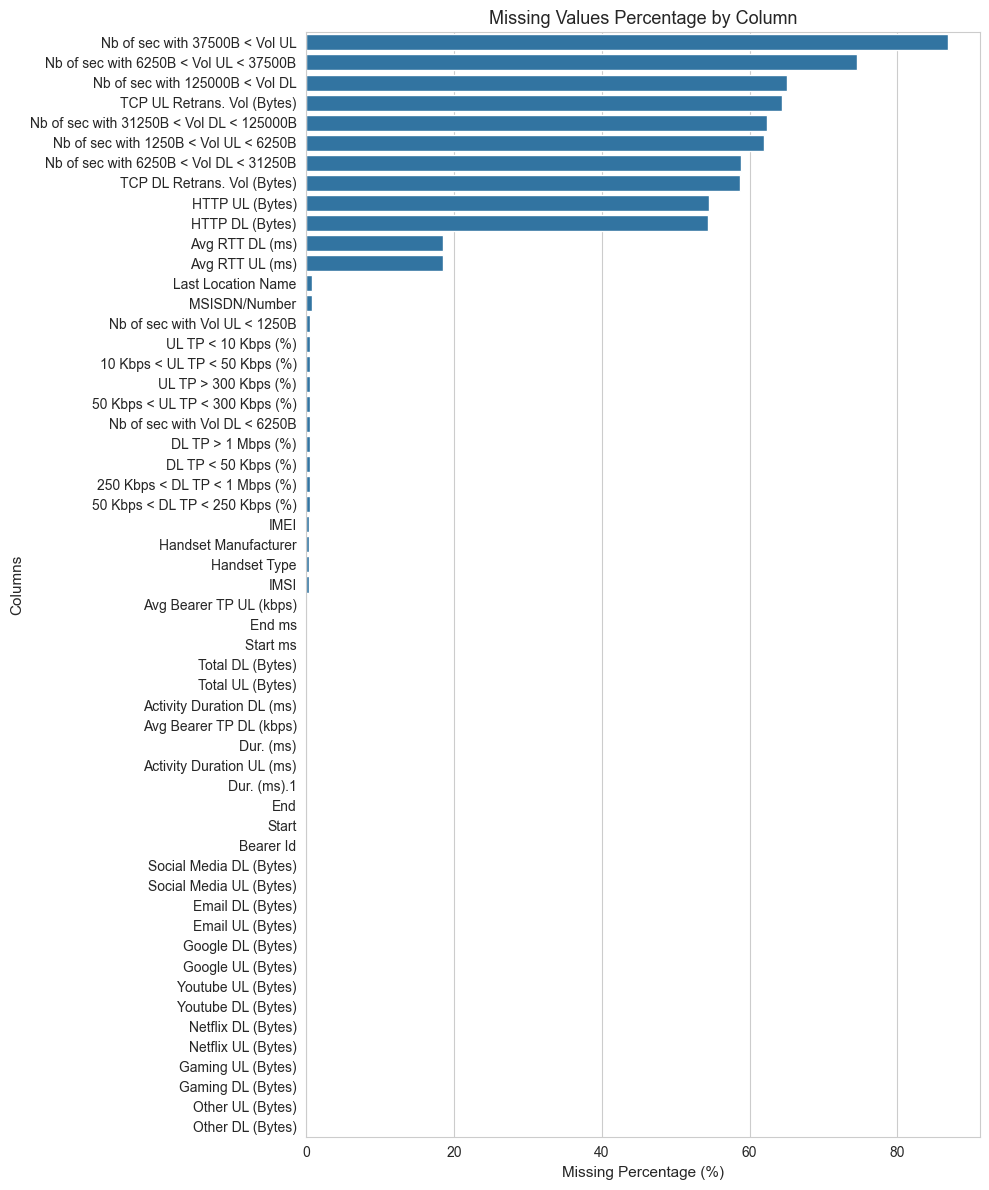

In [18]:
missing_summary = pd.DataFrame({
    'missing_count': df.isnull().sum(),
    'missing_percent': (df.isnull().sum() / len(df)) * 100
}).sort_values(by='missing_percent', ascending=False)

missing_summary
plt.figure(figsize=(10, 12))

ax = sns.barplot(
    y=missing_summary.index,
    x=missing_summary['missing_percent'],
)

ax.set_xlabel("Missing Percentage (%)", fontsize=11)
ax.set_ylabel("Columns", fontsize=11)
ax.set_title("Missing Values Percentage by Column", fontsize=13)

plt.tight_layout()
plt.show()

### Dropping Columns with very high missing percentage
As per standard procedures to clean the data, it is important to drop the columns in TellCo dataset to drop, because they bring no meaning to the anlaysis. Hence dropping the columns using the methods below:


In [19]:
drop_summary = (
    df.isnull()
      .sum()
      .to_frame(name='missing_count')
)

drop_summary['missing_percent'] = (
    drop_summary['missing_count'] / len(df)
) * 100

drop_summary = drop_summary.sort_values(
    by='missing_percent',
    ascending=False
)


cols_before = set(df.columns)

drop_cols_existing = (
    drop_summary
        .loc[drop_summary['missing_percent'] > 40]
        .index
        .intersection(df.columns)
)

df = df.drop(columns=drop_cols_existing)

dropped_columns = sorted(cols_before - set(df.columns))

logger.info(
    f'Dropped columns with >40% missing values: {dropped_columns}'
)

2025-12-22 12:42:35 | INFO | telecom_pipeline | Dropped columns with >40% missing values: ['HTTP DL (Bytes)', 'HTTP UL (Bytes)', 'Nb of sec with 125000B < Vol DL', 'Nb of sec with 1250B < Vol UL < 6250B', 'Nb of sec with 31250B < Vol DL < 125000B', 'Nb of sec with 37500B < Vol UL', 'Nb of sec with 6250B < Vol DL < 31250B', 'Nb of sec with 6250B < Vol UL < 37500B', 'TCP DL Retrans. Vol (Bytes)', 'TCP UL Retrans. Vol (Bytes)']


### Remove Duplicate Records
It is important to remove the duplicated from the TellCo dataset to get the accuracy and which can help us in avoiding the vague results due to duplicacy.

In [20]:
# Get the duplicate data in the rows
duplicate_rows = df[df.duplicated(keep=False)]
duplicate_rows
logger.info(f'Found {len(duplicate_rows)} duplicate rows in the DataFrame.')

# Count of duplicate rows
duplicate_rows_count = df.duplicated(keep=False).sum()
duplicate_rows_count
logger.info(f'Number of duplicate rows: {duplicate_rows_count}')

# Drop duplicate rows
df = df.drop_duplicates()
logger.info(f'After cleaning, DataFrame shape: {df.shape}')

2025-12-22 12:42:36 | INFO | telecom_pipeline | Found 0 duplicate rows in the DataFrame.
2025-12-22 12:42:36 | INFO | telecom_pipeline | Number of duplicate rows: 0
2025-12-22 12:42:37 | INFO | telecom_pipeline | After cleaning, DataFrame shape: (150001, 45)


### Remove Constant / Near-Zero Variance Columns

In [21]:

df = df.loc[:, df.nunique() > 1]
logger.info(f'After removing constant columns, DataFrame shape: {df.shape}')

2025-12-22 12:42:38 | INFO | telecom_pipeline | After removing constant columns, DataFrame shape: (150001, 45)


### Fill numeric missing values with mean

In [22]:
numeric_cols = df.select_dtypes(include=["number"]).columns.tolist()
categorical_cols = df.select_dtypes(include=["object", "category"]).columns.tolist()

df[numeric_cols] = df[numeric_cols].apply(
    lambda col: col.fillna(col.mean())
)

for col in categorical_cols:
    if not df[col].mode().empty:
        df[col] = df[col].fillna(df[col].mode()[0])

logger.info("Missing values handled safely using dynamic schema detection.")


2025-12-22 12:42:39 | INFO | telecom_pipeline | Missing values handled safely using dynamic schema detection.


### Validation of the dataset after cleaning process

In [23]:
df.info()
df.isnull().sum().sum()   # should be 0 or very low
df.describe()
logger.info('Final DataFrame info displayed.')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150001 entries, 0 to 150000
Data columns (total 45 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   Bearer Id                       150001 non-null  object 
 1   Start                           150001 non-null  int64  
 2   Start ms                        150001 non-null  float64
 3   End                             150001 non-null  int64  
 4   End ms                          150001 non-null  float64
 5   Dur. (ms)                       150001 non-null  float64
 6   IMSI                            150001 non-null  float64
 7   MSISDN/Number                   150001 non-null  float64
 8   IMEI                            150001 non-null  float64
 9   Last Location Name              150001 non-null  object 
 10  Avg RTT DL (ms)                 150001 non-null  float64
 11  Avg RTT UL (ms)                 150001 non-null  float64
 12  Avg Bearer TP DL

2025-12-22 12:42:39 | INFO | telecom_pipeline | Final DataFrame info displayed.


### Data Dictionary (Sheet)
This will add the Feature name and descriptions about it.

In [24]:
data_dictionary = [
    ("bearer id", "Unique identifier for the bearer session"),
    ("Dur. (ms)", "Duration of the session in milliseconds"),
    ("Start", "Start timestamp of the session"),
    ("Start ms", "Start time in milliseconds"),
    ("End", "End timestamp of the session"),
    ("End ms", "End time in milliseconds"),
    ("Dur. (s)", "Duration of the session in seconds"),
    ("IMSI", "International Mobile Subscriber Identity"),
    ("MSISDN/Number", "Mobile Subscriber ISDN Number"),
    ("IMEI", "International Mobile Equipment Identity"),
    ("Last Location Name", "Last recorded cell tower or location name"),
    ("Avg RTT DL (ms)", "Average round-trip time for downlink in milliseconds"),
    ("Avg RTT UL (ms)", "Average round-trip time for uplink in milliseconds"),
    ("Avg Bearer TP DL (kbps)", "Average downlink throughput in kbps"),
    ("Avg Bearer TP UL (kbps)", "Average uplink throughput in kbps"),
    ("TCP DL Retrans. Vol (Bytes)", "TCP downlink retransmission volume in bytes"),
    ("TCP UL Retrans. Vol (Bytes)", "TCP uplink retransmission volume in bytes"),
    ("DL TP < 50 Kbps (%)", "Percentage of time downlink throughput was below 50 Kbps"),
    ("50 Kbps < DL TP < 250 Kbps (%)", "Percentage of time downlink throughput was between 50 and 250 Kbps"),
    ("250 Kbps < DL TP < 1 Mbps (%)", "Percentage of time downlink throughput was between 250 Kbps and 1 Mbps"),
    ("DL TP > 1 Mbps (%)", "Percentage of time downlink throughput exceeded 1 Mbps"),
    ("UL TP < 10 Kbps (%)", "Percentage of time uplink throughput was below 10 Kbps"),
    ("10 Kbps < UL TP < 50 Kbps (%)", "Percentage of time uplink throughput was between 10 and 50 Kbps"),
    ("UL TP > 50 Kbps (%)", "Percentage of time uplink throughput exceeded 50 Kbps"),
    ("HTTP DL (Bytes)", "HTTP downlink data volume in bytes"),
    ("HTTP UL (Bytes)", "HTTP uplink data volume in bytes"),
    ("Total DL (Bytes)", "Total downlink data volume in bytes"),
    ("Total UL (Bytes)", "Total uplink data volume in bytes"),
    ("Social Media DL (Bytes)", "Social media data volume received in bytes"),
    ("Social Media UL (Bytes)", "Social media data volume sent in bytes"),
    ("YouTube DL (Bytes)", "YouTube data volume received in bytes"),
    ("YouTube UL (Bytes)", "YouTube data volume sent in bytes"),
    ("Netflix DL (Bytes)", "Netflix data volume received in bytes"),
    ("Netflix UL (Bytes)", "Netflix data volume sent in bytes"),
    ("Google DL (Bytes)", "Google services data volume received in bytes"),
    ("Google UL (Bytes)", "Google services data volume sent in bytes"),
    ("Email DL (Bytes)", "Email data volume received in bytes"),
    ("Email UL (Bytes)", "Email data volume sent in bytes"),
    ("Gaming DL (Bytes)", "Gaming data volume received in bytes"),
    ("Gaming UL (Bytes)", "Gaming data volume sent in bytes"),
    ("Other DL (Bytes)", "Other application data volume received in bytes"),
    ("Other UL (Bytes)", "Other application data volume sent in bytes"),
    ("Total Data DL (Bytes)", "Total data volume received during the session"),
    ("Total Data UL (Bytes)", "Total data volume sent during the session"),
]

dd_df = pd.DataFrame(
    data_dictionary,
    columns=["Feature Name", "Description"]
)

### Correlation 
The correlation is usually between numeric values, we would be finding the correlation by using `corr()` in the TellCo dataset.
By using `numeric_only=True`, we will be targetting the numeric columns of the dataset to get to know how they are related to each other.
Correlation will be working only with numeric features, otherwise it will fail and throw error.

In [25]:
df.corr(numeric_only=True)
logger.info("Correlation matrix computed for numeric features.")

2025-12-22 12:42:41 | INFO | telecom_pipeline | Correlation matrix computed for numeric features.


### Visualization of the correlation
Visualization will be done using a heat map and for that we will use:
- seaborn (sns)
- matplotlib.pyplot (plt)

`plt.rcParams` is used to style the figure of heatmap as without it may show it, but small in size, which will overlap the data. So, using it would let us define the size of the heatmap.

`annot=True` help us get the numerical data present over the heatmap, otherwise it will be a plain heatmap which would not contain the numeric values.

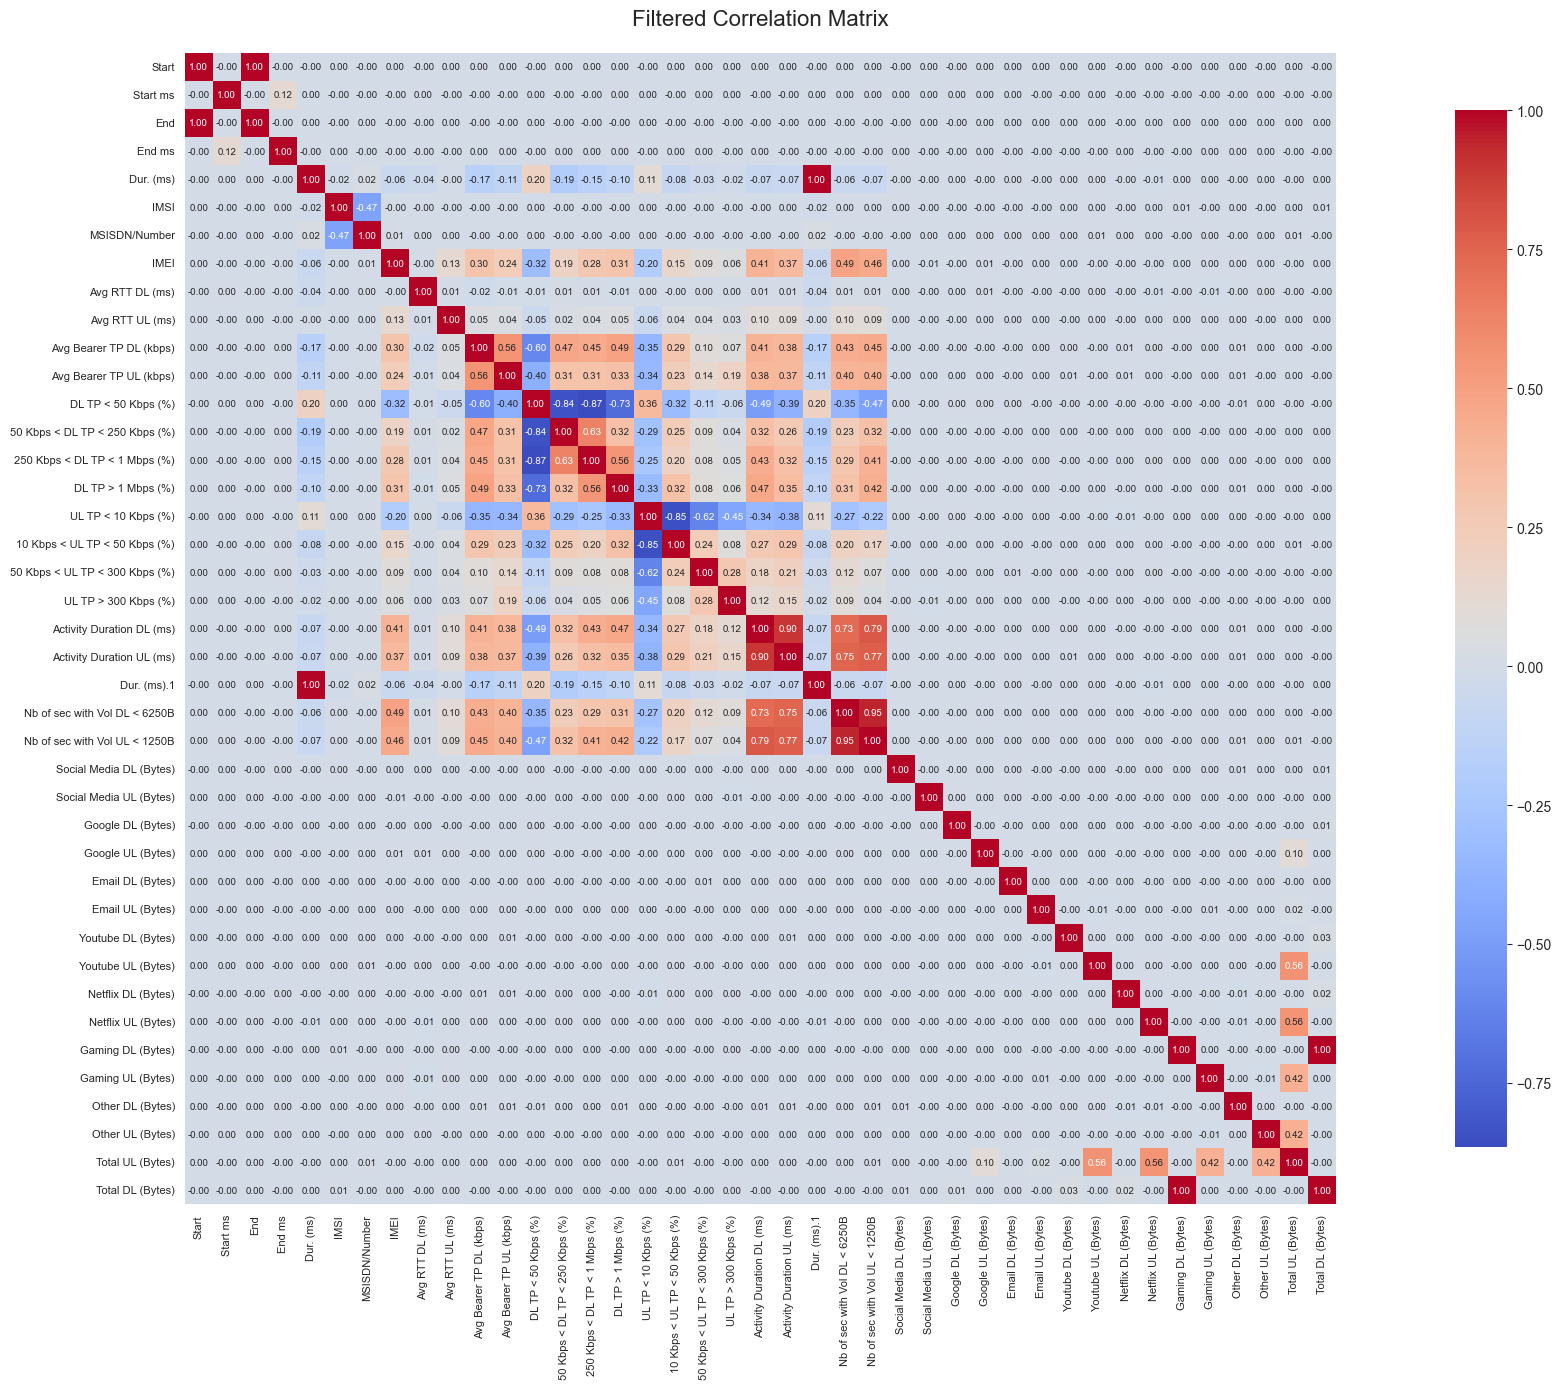

2025-12-22 12:42:48 | INFO | telecom_pipeline | Filtered correlation heatmap plotted.


In [26]:
num_df = df.select_dtypes(include='number')

# Step 2: remove constant columns
num_df = num_df.loc[:, num_df.nunique() > 1]

# Step 3: correlation
corr = num_df.corr()

# Step 4: keep only strong correlations
threshold = 0.6
filtered_corr = corr.loc[
    corr.abs().max(axis=1) > threshold,
    corr.abs().max(axis=0) > threshold
]

# Step 5: plot (NO overlap)
plt.figure(figsize=(24, 14))  # BIGGER heatmap

ax = sns.heatmap(
    filtered_corr,
    cmap='coolwarm',
    square=True,
    cbar_kws={'shrink': 0.9},
    annot=True,
    fmt='.2f',
    annot_kws={'size': 7}
)

# Reduce axis label font size
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=90,
    fontsize=8
)
ax.set_yticklabels(
    ax.get_yticklabels(),
    fontsize=8
)

plt.title(
    "Filtered Correlation Matrix",
    fontsize=16,
    pad=20
)

plt.tight_layout()
plt.show()

logger.info("Filtered correlation heatmap plotted.")

### Detect Potential Outliers (Numeric Columns)
Using IQR(Interquartile Range) method:
For each numeric feature:

- Calculate Q1 and Q3
- Compute IQR
- Determine lower & upper bounds:
  [Q1 − 1.5 × IQR , Q3 + 1.5 × IQR]
- Count how many values fall outside the bounds
- Store results for reporting

In [27]:
# -------------------------------------------------
# OUTLIER SUMMARY (CORRECT & COMPLETE)
# -------------------------------------------------

outlier_summary = []

for col in numeric_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outlier_mask = (df[col] < lower_bound) | (df[col] > upper_bound)
    outlier_count = outlier_mask.sum()
    total_count = df[col].notna().sum()
    outlier_pct = round((outlier_count / total_count) * 100, 2) if total_count > 0 else 0

    outlier_summary.append({
        "Feature": col,
        "Q1": round(Q1, 3),
        "Q3": round(Q3, 3),
        "IQR": round(IQR, 3),
        "Lower Bound": round(lower_bound, 3),
        "Upper Bound": round(upper_bound, 3),
        "Outlier Count": outlier_count,
        "Outlier %": outlier_pct
    })

# Create DataFrame AFTER loop
outliers_df = pd.DataFrame(outlier_summary)
if outliers_df["Outlier Count"].sum() == 0:
    outliers_df = pd.DataFrame({
        "Message": ["No outliers detected in numeric features using IQR method"]
    })
    logger.info("No outliers detected in the dataset")

logger.info("Outlier summary DataFrame created successfully")


2025-12-22 12:42:48 | INFO | telecom_pipeline | Outlier summary DataFrame created successfully


Converting collected IQR results into a pandas DataFrame and display it. Also logs completion message.

In [28]:
iqr_df = pd.DataFrame(outlier_summary)
display(iqr_df)

logger.info(f"IQR outlier detection complete for {len(numeric_cols)} numeric columns.")

,Feature,Q1,Q3,IQR,Lower Bound,Upper Bound,Outlier Count,Outlier %
0,Start,1.556152e+18,1.556389e+18,2.371780e+14,1.555796e+18,1.556745e+18,480,0.32
1,Start ms,2.500000e+02,7.490000e+02,4.990000e+02,-4.985000e+02,1.497500e+03,0,0.00
2,End,1.556264e+18,1.556522e+18,2.582970e+14,1.555876e+18,1.556910e+18,1,0.00
3,End ms,2.510000e+02,7.500000e+02,4.990000e+02,-4.975000e+02,1.498500e+03,0,0.00
4,Dur. (ms),5.744200e+04,1.324300e+05,7.498800e+04,-5.504000e+04,2.449120e+05,7184,4.79
5,IMSI,2.082014e+14,2.082018e+14,3.703424e+08,2.082008e+14,2.082023e+14,13250,8.83
6,MSISDN/Number,3.365151e+10,3.368473e+10,3.322217e+07,3.360168e+10,3.373456e+10,24742,16.49
7,IMEI,3.546261e+13,8.611970e+13,5.065709e+13,-4.052303e+13,1.621053e+14,0,0.00
8,Avg RTT DL (ms),3.500000e+01,1.097960e+02,7.479600e+01,-7.719400e+01,2.219890e+02,7718,5.15
9,Avg RTT UL (ms),3.000000e+00,1.766300e+01,1.466300e+01,-1.899400e+01,3.965700e+01,8975,5.98


2025-12-22 12:42:48 | INFO | telecom_pipeline | IQR outlier detection complete for 41 numeric columns.


__________________________________________________________________________________________________________________________

## Exploratory Data Analysis (EDA)

Sub-objectives 

We will perform EDA for:
- Univariate Analysis
- Bivariate Analysis
- Multivariate Analysis
- User Overview
- User Engagement
- User Experience
- User Satisfaction

### Univariate Analysis

In [29]:
numeric_cols = df.select_dtypes(include="number").columns

univariate_summary = df[numeric_cols].describe().T
univariate_summary["missing_percent"] = (
    df[numeric_cols].isnull().mean() * 100
)

univariate_summary.reset_index(inplace=True)
univariate_summary.rename(columns={"index": "feature"}, inplace=True)
display(univariate_summary)

,feature,count,mean,std,min,25%,50%,75%,max,missing_percent
0,Start,150001.0,1.556210e+18,2.783325e+16,-9.223372e+18,1.556152e+18,1.556269e+18,1.556389e+18,1.556523e+18,0.0
1,Start ms,150001.0,4.991882e+02,2.886109e+02,0.000000e+00,2.500000e+02,4.990000e+02,7.490000e+02,9.990000e+02,0.0
2,End,150001.0,1.556315e+18,2.783354e+16,-9.223372e+18,1.556264e+18,1.556406e+18,1.556522e+18,1.556669e+18,0.0
3,End ms,150001.0,4.988009e+02,2.880967e+02,0.000000e+00,2.510000e+02,5.000000e+02,7.500000e+02,9.990000e+02,0.0
4,Dur. (ms),150001.0,1.046086e+05,8.103735e+04,7.142000e+03,5.744200e+04,8.639900e+04,1.324300e+05,1.859336e+06,0.0
5,IMSI,150001.0,2.082016e+14,2.144722e+10,2.040471e+14,2.082014e+14,2.082015e+14,2.082018e+14,2.140743e+14,0.0
6,MSISDN/Number,150001.0,4.188282e+10,2.438731e+12,3.360100e+10,3.365151e+10,3.366380e+10,3.368473e+10,8.823971e+14,0.0
7,IMEI,150001.0,4.847455e+13,2.237359e+13,4.400152e+11,3.546261e+13,3.572241e+13,8.611970e+13,9.900120e+13,0.0
8,Avg RTT DL (ms),150001.0,1.097957e+02,5.593426e+02,0.000000e+00,3.500000e+01,5.400000e+01,1.097957e+02,9.692300e+04,0.0
9,Avg RTT UL (ms),150001.0,1.766288e+01,7.652993e+01,0.000000e+00,3.000000e+00,7.000000e+00,1.766288e+01,7.120000e+03,0.0


#### Building a univariate ranking table

In [30]:
numeric_cols = df.select_dtypes(include="number").columns.tolist()

uni_rank = pd.DataFrame({
    "feature": numeric_cols,
    "mean": df[numeric_cols].mean(),
    "median": df[numeric_cols].median(),
    "std": df[numeric_cols].std(),
    "missing_percent": df[numeric_cols].isnull().mean() * 100
}).reset_index(drop=True)

#### Creating a composite “decision score”

We normalize metrics so no single scale dominates.

In [31]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

uni_rank[["mean_n", "std_n"]] = scaler.fit_transform(
    uni_rank[["mean", "std"]]
)

# Higher score = more decision impact
uni_rank["decision_score"] = (
    0.5 * uni_rank["mean_n"] +
    0.5 * uni_rank["std_n"]
)

# Penalize poor data quality
uni_rank.loc[uni_rank["missing_percent"] > 20, "decision_score"] = 0


#### Selecting TOP-3 features

In [32]:
top_features = (
    uni_rank
    .sort_values("decision_score", ascending=False)
    .head(3)
    ["feature"]
    .tolist()
)

top_features


['End', 'Start', 'IMEI']

#### Filename sanitizer

In [33]:
import re

def safe_filename(name: str) -> str:
    name = name.strip()
    name = re.sub(r"[^\w\-_. ]", "_", name)  # replace unsafe chars
    name = name.replace(" ", "_")
    return name

#### Univariate Plots
This is used to display the plots to understand the nature of the data associated with one of the columns/features.
This will lead to understand the relation and nature of the feature(s) graphically.

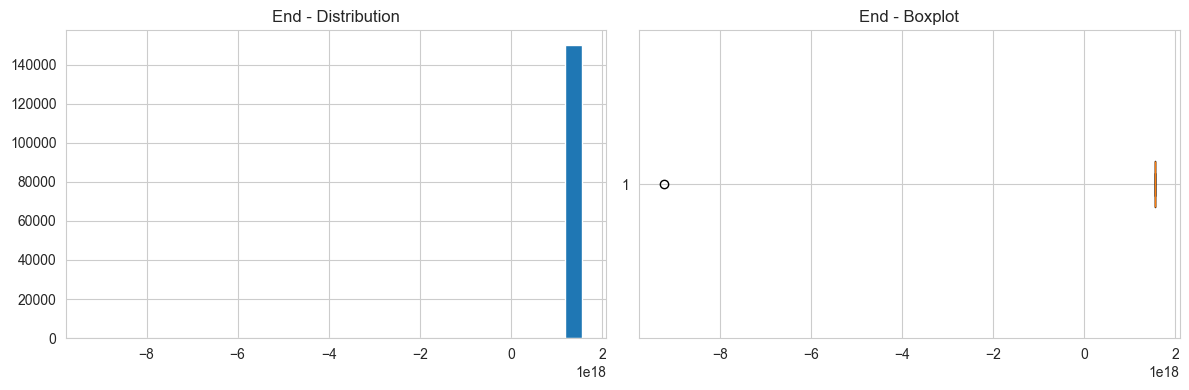

2025-12-22 12:42:50 | INFO | telecom_pipeline | Univariate plots saved for: End at output/plots/univariate\End.png


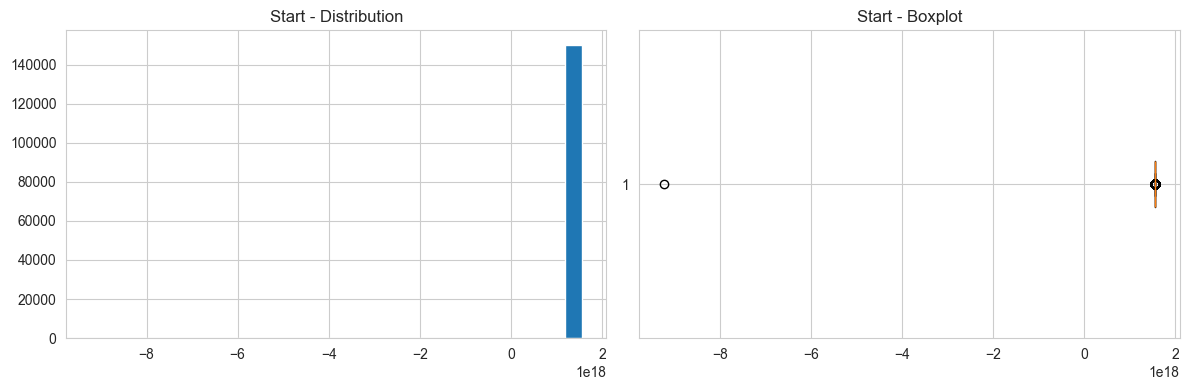

2025-12-22 12:42:51 | INFO | telecom_pipeline | Univariate plots saved for: Start at output/plots/univariate\Start.png


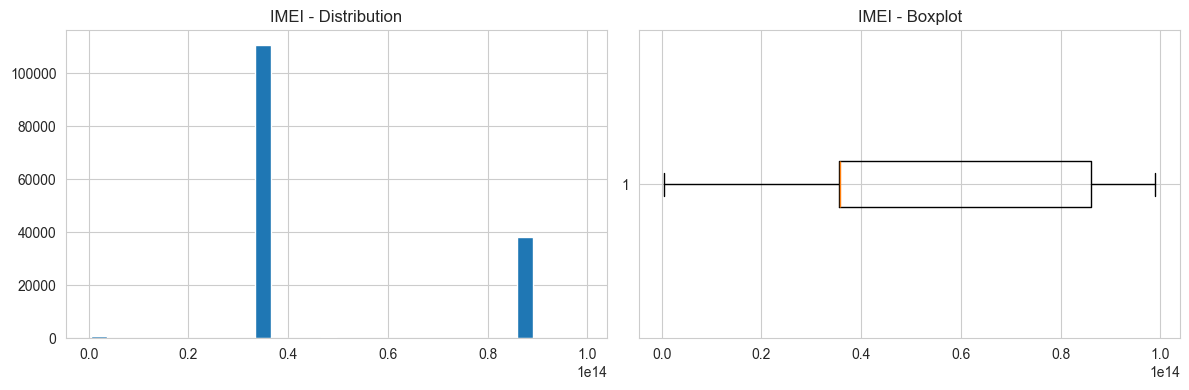

2025-12-22 12:42:51 | INFO | telecom_pipeline | Univariate plots saved for: IMEI at output/plots/univariate\IMEI.png


In [34]:
plot_dir = "output/plots/univariate"
os.makedirs(plot_dir, exist_ok=True)

plot_paths = []

for col in top_features:
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    # Histogram
    axes[0].hist(df[col].dropna(), bins=30)
    axes[0].set_title(f"{col} - Distribution")

    # Boxplot
    axes[1].boxplot(df[col].dropna(), vert=False)
    axes[1].set_title(f"{col} - Boxplot")

    plt.tight_layout()

    safe_col = safe_filename(col)
    plot_path = os.path.join(plot_dir, f"{safe_col}.png")

    plt.savefig(plot_path, dpi=120)
    plt.show()
    plt.close()

    plot_paths.append(plot_path)
    logger.info(f"Univariate plots saved for: {col} at {plot_path}")

#### Store plot paths in paraquet

In [35]:
plot_paths = {}

for col in top_features:
    ...
    plot_path = os.path.join(plot_dir, f"{safe_col}.png")
    plt.savefig(plot_path, dpi=120)
    plt.close()

    plot_paths[col] = plot_path

univariate_summary["plot_path"] = univariate_summary["feature"].map(plot_paths)

univariate_summary.to_parquet(
    "data/univariate_summary.parquet",
    index=False
)


## Bivariate Analysis (Correlation)
Correlation driven bivariate analysis will be performed here resulting in plots to display as a graphical data. This will help in getting better insights to take better decisions.

Goal:
- Auto-detect strongly correlated numeric pairs
- Avoid IDs / categorical noise
- Plot the top decision-useful pairs in the notebook
- Keep it scalable for large data

#### Getting the columns from the cleaned dataset. We are naming those columns as `allowed_cols`

In [36]:
allowed_cols = [
    'Bearer Id', 'Start ms', 'End ms', 'Dur. (ms)', 'IMSI',
    'Avg RTT DL (ms)', 'Avg RTT UL (ms)',
    'Avg Bearer TP DL (kbps)', 'Avg Bearer TP UL (kbps)',
    'DL TP < 50 Kbps (%)', '50 Kbps < DL TP < 250 Kbps (%)',
    '250 Kbps < DL TP < 1 Mbps (%)', 'DL TP > 1 Mbps (%)',
    'UL TP < 10 Kbps (%)', '10 Kbps < UL TP < 50 Kbps (%)',
    '50 Kbps < UL TP < 300 Kbps (%)', 'UL TP > 300 Kbps (%)',
    'Activity Duration DL (ms)', 'Activity Duration UL (ms)', 'Dur. (ms).1',
    'Nb of sec with Vol DL < 6250B',
    'Nb of sec with Vol UL < 1250B',
    'Social Media DL (Bytes)', 'Social Media UL (Bytes)',
    'Google DL (Bytes)', 'Google UL (Bytes)',
    'Email DL (Bytes)', 'Email UL (Bytes)',
    'Youtube DL (Bytes)', 'Youtube UL (Bytes)',
    'Netflix DL (Bytes)', 'Netflix UL (Bytes)',
    'Gaming DL (Bytes)', 'Gaming UL (Bytes)',
    'Other DL (Bytes)', 'Other UL (Bytes)',
    'Total UL (Bytes)', 'Total DL (Bytes)'
]

#### Selecting the numeric columns/features from the data - Bivariate Analysis

In [37]:
numeric_bi_cols = (
    df[allowed_cols]
    .select_dtypes(include="number")
    .columns
)

logger.info(f"Numeric columns used: {len(numeric_bi_cols)}")
logger.info(numeric_bi_cols.tolist())

2025-12-22 12:42:52 | INFO | telecom_pipeline | Numeric columns used: 37
2025-12-22 12:42:52 | INFO | telecom_pipeline | ['Start ms', 'End ms', 'Dur. (ms)', 'IMSI', 'Avg RTT DL (ms)', 'Avg RTT UL (ms)', 'Avg Bearer TP DL (kbps)', 'Avg Bearer TP UL (kbps)', 'DL TP < 50 Kbps (%)', '50 Kbps < DL TP < 250 Kbps (%)', '250 Kbps < DL TP < 1 Mbps (%)', 'DL TP > 1 Mbps (%)', 'UL TP < 10 Kbps (%)', '10 Kbps < UL TP < 50 Kbps (%)', '50 Kbps < UL TP < 300 Kbps (%)', 'UL TP > 300 Kbps (%)', 'Activity Duration DL (ms)', 'Activity Duration UL (ms)', 'Dur. (ms).1', 'Nb of sec with Vol DL < 6250B', 'Nb of sec with Vol UL < 1250B', 'Social Media DL (Bytes)', 'Social Media UL (Bytes)', 'Google DL (Bytes)', 'Google UL (Bytes)', 'Email DL (Bytes)', 'Email UL (Bytes)', 'Youtube DL (Bytes)', 'Youtube UL (Bytes)', 'Netflix DL (Bytes)', 'Netflix UL (Bytes)', 'Gaming DL (Bytes)', 'Gaming UL (Bytes)', 'Other DL (Bytes)', 'Other UL (Bytes)', 'Total UL (Bytes)', 'Total DL (Bytes)']


#### Computing the correlation matrix - Bivariate Analysis

In [38]:
corr_matrix = df[numeric_bi_cols].corr()

#### Extract top correlated pairs automatically - Bivariate Analysis

In [39]:
corr_pairs = (
    corr_matrix
    .where(~np.eye(corr_matrix.shape[0], dtype=bool))
    .stack()
    .reset_index()
)

corr_pairs.columns = ["Feature 1", "Feature 2", "Correlation"]

# Remove duplicate pairs (A,B) & (B,A)
corr_pairs["abs_corr"] = corr_pairs["Correlation"].abs()
corr_pairs = corr_pairs.sort_values("abs_corr", ascending=False)

corr_pairs = corr_pairs.drop_duplicates(
    subset=["abs_corr"]
)

top_corr_pairs = corr_pairs.head(5)

top_corr_pairs


,Feature 1,Feature 2,Correlation,abs_corr
89,Dur. (ms),Dur. (ms).1,1.000000,1.000000
1151,Gaming DL (Bytes),Total DL (Bytes),0.999131,0.999131
703,Nb of sec with Vol DL < 6250B,Nb of sec with Vol UL < 1250B,0.946121,0.946121
628,Activity Duration UL (ms),Activity Duration DL (ms),0.904458,0.904458
368,250 Kbps < DL TP < 1 Mbps (%),DL TP < 50 Kbps (%),-0.865053,0.865053


#### Plot top correlated bivariate pairs (Notebook) - Bivariate Analysis

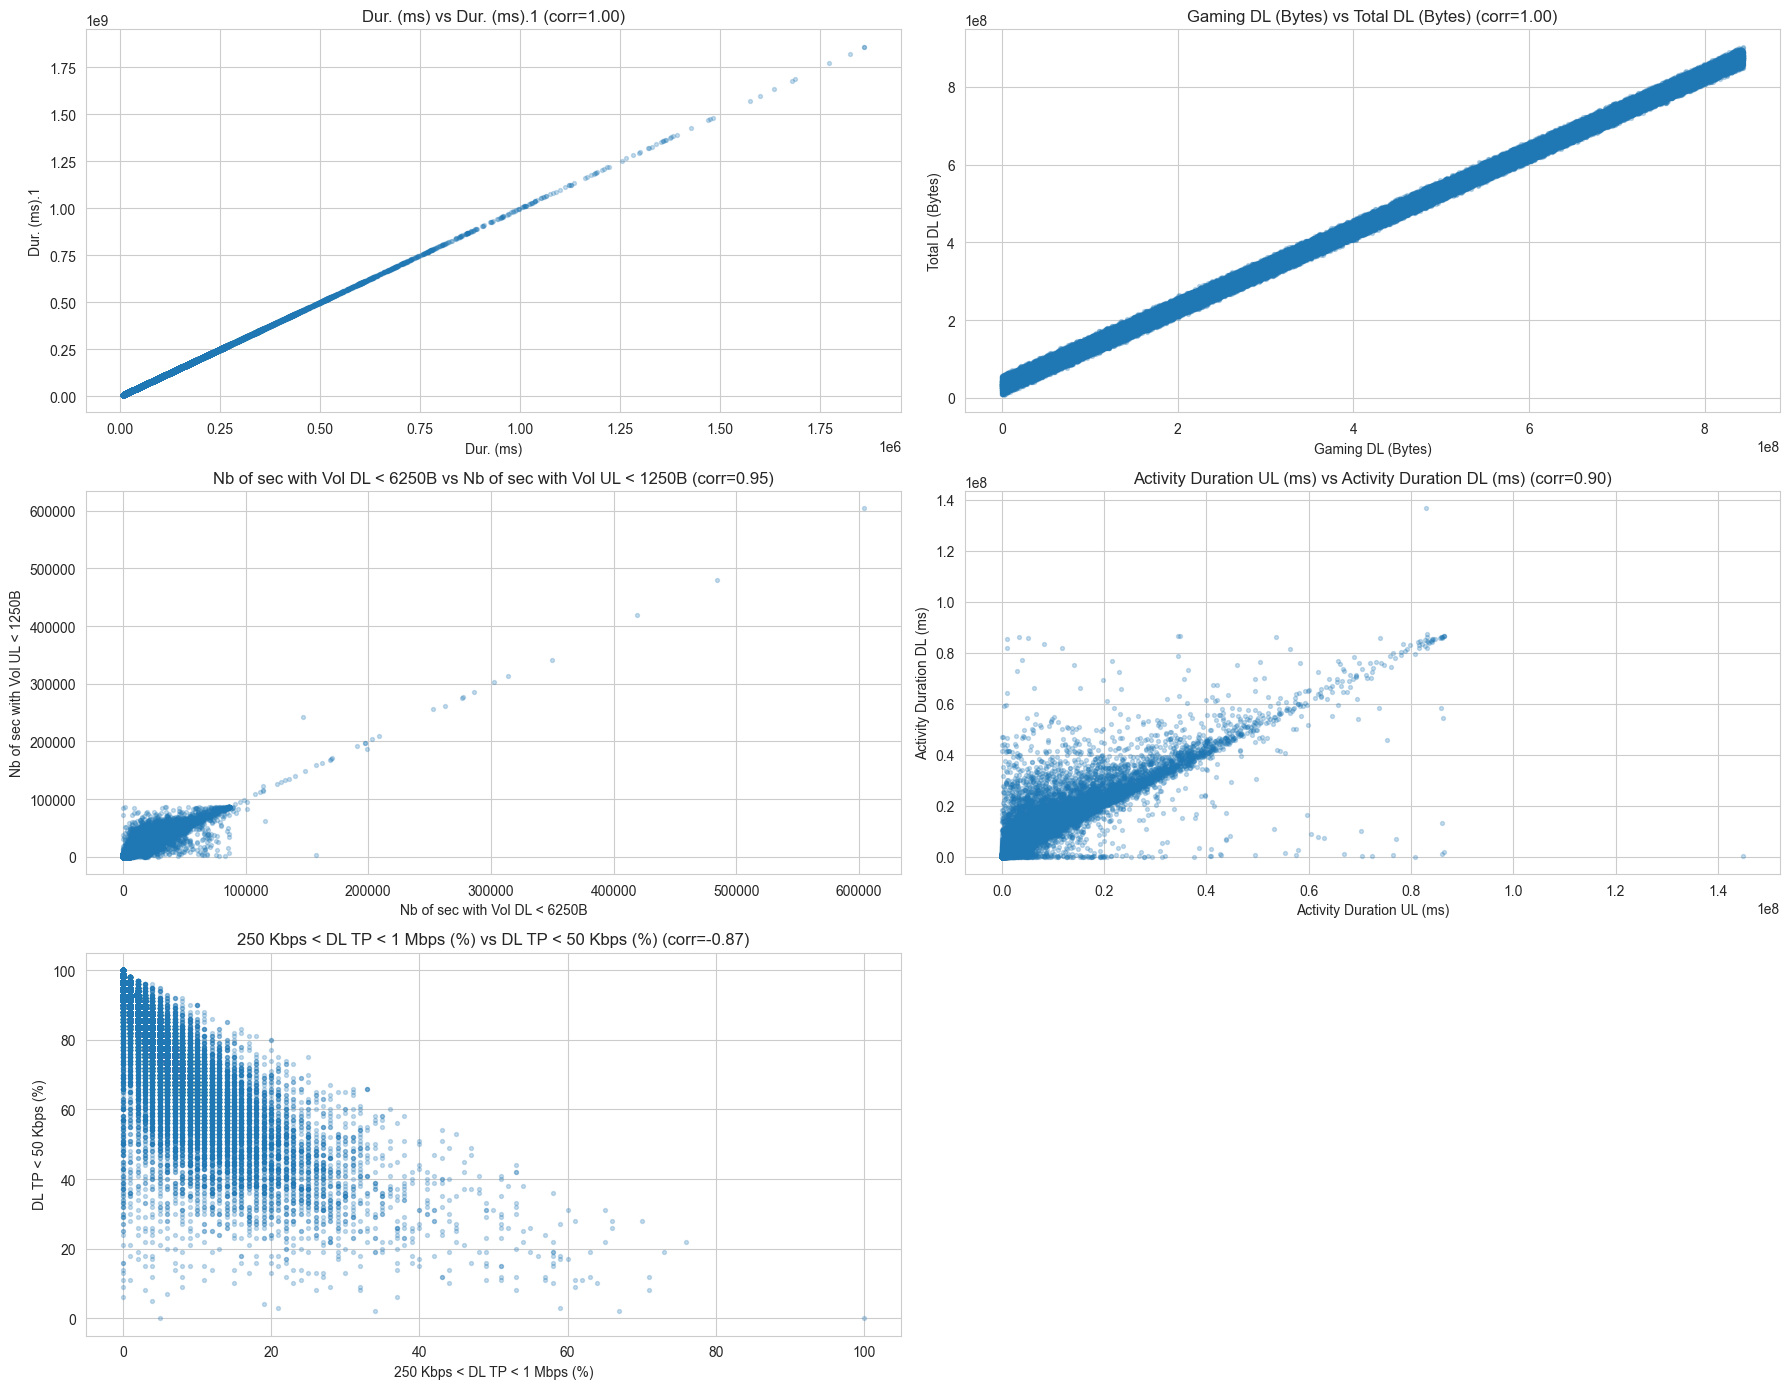

2025-12-22 12:42:58 | INFO | telecom_pipeline | Bivariate scatter plots generated and saved at output/plots/bivariate\top_correlated_pairs.png for feature pairs: Dur. (ms) vs Dur. (ms).1; Gaming DL (Bytes) vs Total DL (Bytes); Nb of sec with Vol DL < 6250B vs Nb of sec with Vol UL < 1250B; Activity Duration UL (ms) vs Activity Duration DL (ms); 250 Kbps < DL TP < 1 Mbps (%) vs DL TP < 50 Kbps (%)


In [40]:
bivariate_plot_dir = "output/plots/bivariate"
os.makedirs(bivariate_plot_dir, exist_ok=True)

plt.figure(figsize=(18, 14))

plotted_pairs = []

for i, (_, row) in enumerate(top_corr_pairs.iterrows(), 1):
    x = row["Feature 1"]
    y = row["Feature 2"]
    corr_val = row["Correlation"]

    plt.subplot(3, 2, i)
    plt.scatter(df[x], df[y], alpha=0.25, s=8)
    plt.xlabel(x)
    plt.ylabel(y)
    plt.title(f"{x} vs {y} (corr={corr_val:.2f})")

    plotted_pairs.append(f"{x} vs {y}")

plt.tight_layout()

plot_path = os.path.join(bivariate_plot_dir, "top_correlated_pairs.png")
plt.savefig(plot_path, dpi=120)
plt.show()
plt.close()

logger.info(
    "Bivariate scatter plots generated and saved at %s for feature pairs: %s",
    plot_path,
    "; ".join(plotted_pairs)
)


#### Decision-ready bivariate summary table - Bivariate Analysis

In [41]:
bivariate_summary = top_corr_pairs[[
    "Feature 1",
    "Feature 2",
    "Correlation"
]].reset_index(drop=True)

bivariate_summary

,Feature 1,Feature 2,Correlation
0,Dur. (ms),Dur. (ms).1,1.000000
1,Gaming DL (Bytes),Total DL (Bytes),0.999131
2,Nb of sec with Vol DL < 6250B,Nb of sec with Vol UL < 1250B,0.946121
3,Activity Duration UL (ms),Activity Duration DL (ms),0.904458
4,250 Kbps < DL TP < 1 Mbps (%),DL TP < 50 Kbps (%),-0.865053


#### Bivariate Analysis - Concluding Statement
Total download volume is strongly driven by high-bandwidth applications such as YouTube, Netflix, and Gaming, indicating these services dominate network usage.
Higher throughput and longer activity durations are consistently associated with increased data consumption.
This confirms that both application type and network performance are key drivers of user engagement and network load.

________________________________________________________________________________________________________________________________________

## Multivariate Analysis – Principal Component Analysis (PCA)
Objective:
- To reduce dimensionality of multiple numeric features while preserving maximum variance, and to understand combined feature behavior.

#### Feature Selection for Multivariate Analysis
We select only numeric features for PCA to ensure meaningful variance computation and avoid categorical noise.

In [42]:
numeric_cols = df.select_dtypes(include=["int64", "float64"]).columns.tolist()

#### Feature Scaling (Standardization) - Multivariate Analysis
PCA is sensitive to feature scale.
Standardization ensures all variables contribute equally to the analysis.

In [43]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[numeric_cols])

#### Apply PCA Transformation -Multivariate Analysis
PCA is applied to transform the original feature space into orthogonal principal components that capture maximum variance.

In [44]:
pca = PCA(n_components=3)
pca.fit(X_scaled)

,n_components,3
,copy,True
,whiten,False
,svd_solver,'auto'
,tol,0.0
,iterated_power,'auto'
,n_oversamples,10
,power_iteration_normalizer,'auto'
,random_state,None


#### PCA Variance Explanation Summary - Multivariate Analysis
Explained Variance Ratio shows how much information (variance) is retained by each principal component.

In [45]:
pca_summary = pd.DataFrame(
    pca.explained_variance_ratio_,
    index=["PC1", "PC2", "PC3"],
    columns=["Explained Variance Ratio"]
)

pca_summary
logger.info("PCA analysis complete.")

2025-12-22 12:42:59 | INFO | telecom_pipeline | PCA analysis complete.


#### PCA Transformation of Data
The standardized data is projected onto the principal component space to visualize multivariate relationships.

In [46]:
X_pca = pca.transform(X_scaled)

pca_df = pd.DataFrame(
    X_pca,
    columns=["PC1", "PC2", "PC3"]
)

#### PCA Biplot (PC1 vs PC2)
PCA Biplot displays:

- Data points projected in reduced space
- Feature loadings showing variable influence on principal components

2025-12-22 12:42:59 | INFO | telecom_pipeline | PCA biplot plotted with top feature loadings.


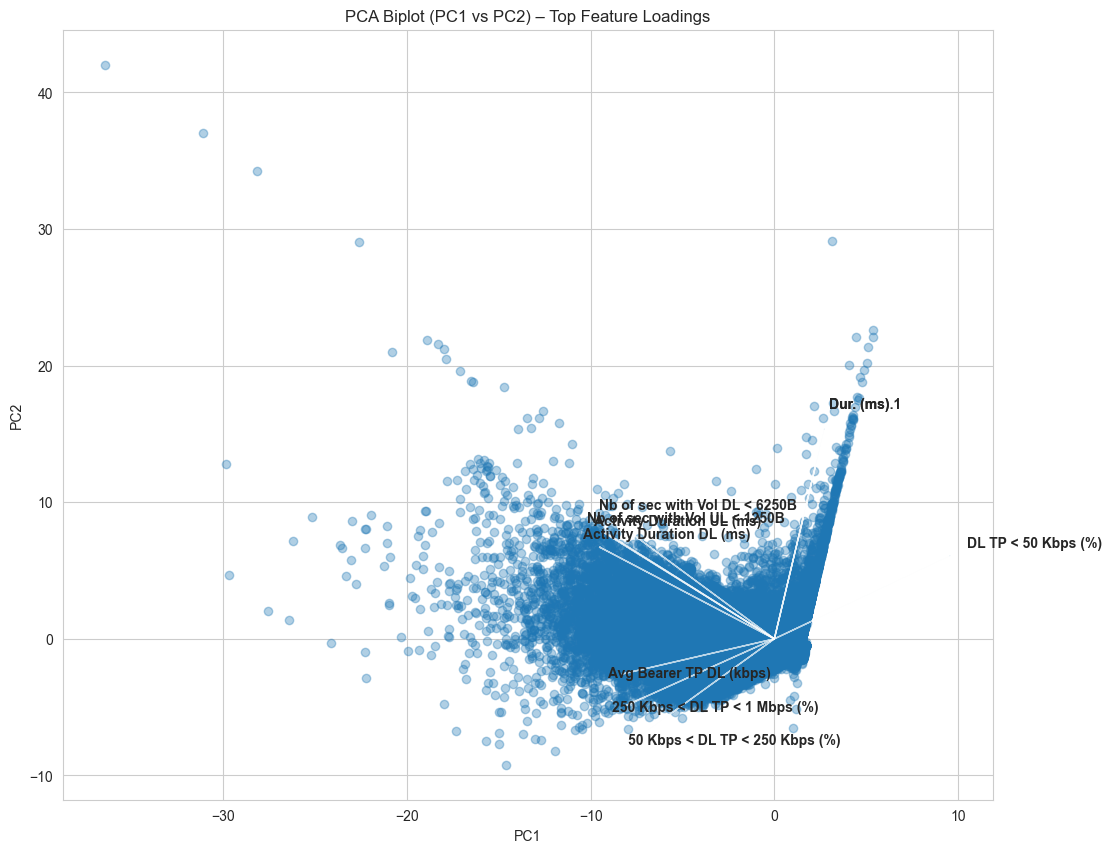

2025-12-22 12:43:02 | INFO | telecom_pipeline | PCA biplot saved at output/plots/multivariate\pca_biplot_pc1_pc2.png


In [47]:
# ----------------------------------------
# Create output directory
# ----------------------------------------
plot_dir = "output/plots/multivariate"
os.makedirs(plot_dir, exist_ok=True)

# ----------------------------------------
# Prepare loadings
# ----------------------------------------
loadings = pca.components_.T[:, :2]  # PC1 & PC2
loading_magnitude = np.sqrt(loadings[:, 0]**2 + loadings[:, 1]**2)

# Select top features by contribution
top_n = 10
top_idx = np.argsort(loading_magnitude)[-top_n:]

# ----------------------------------------
# Plot PCA Biplot
# ----------------------------------------
plt.figure(figsize=(12, 10))

# Scatter PCA points
plt.scatter(
    pca_df["PC1"],
    pca_df["PC2"],
    alpha=0.35
)

# Scale arrows dynamically
scaling_factor = np.max(np.abs(pca_df[["PC1", "PC2"]].values)) * 0.7

for i in top_idx:
    plt.arrow(
        0, 0,
        loadings[i, 0] * scaling_factor,
        loadings[i, 1] * scaling_factor,
        alpha=0.7,
        head_width=0.05
    )
    plt.text(
        loadings[i, 0] * scaling_factor * 1.1,
        loadings[i, 1] * scaling_factor * 1.1,
        numeric_cols[i],
        fontsize=10,
        weight="bold"
    )

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA Biplot (PC1 vs PC2) – Top Feature Loadings")
plt.grid(True)
logger.info("PCA biplot plotted with top feature loadings.")

# ----------------------------------------
# Save plot
# ----------------------------------------
plot_path = os.path.join(plot_dir, "pca_biplot_pc1_pc2.png")
plt.savefig(plot_path, dpi=150, bbox_inches="tight")
plt.show()
plt.close()

logger.info(f"PCA biplot saved at {plot_path}")


#### 3D PCA Scatter Plot (PC1, PC2, PC3)
3D PCA scatter visualizes combined multivariate structure, helping identify:

- Natural clusters
- Outliers
- High-density regions

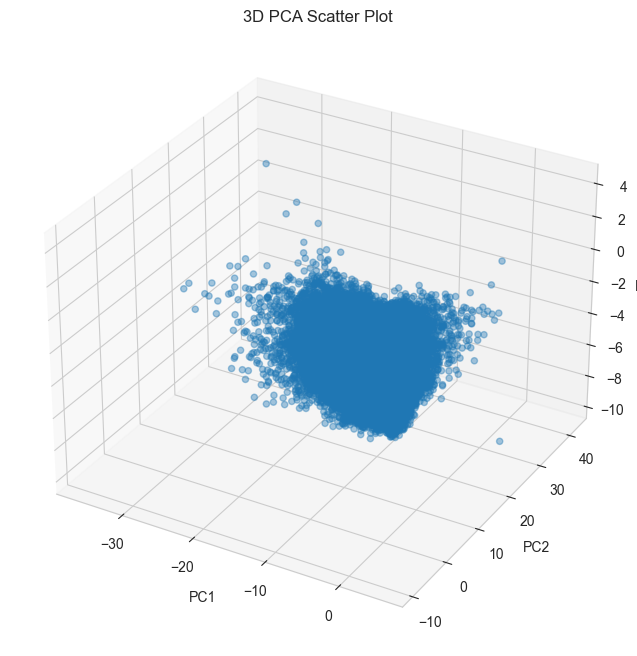

2025-12-22 12:43:09 | INFO | telecom_pipeline | 3D PCA scatter plot displayed.


In [48]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection="3d")

ax.scatter(
    pca_df["PC1"],
    pca_df["PC2"],
    pca_df["PC3"],
    alpha=0.4
)

ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
ax.set_title("3D PCA Scatter Plot")

plt.show()
logger.info("3D PCA scatter plot displayed.")

#### Interpretation - Multivariate Analysis
- PC1 captures the highest variance, representing the dominant combined behavior of numeric features.
- PC2 and PC3 add incremental insights, highlighting secondary interaction patterns.
- Most information is retained using only three components, enabling efficient dimensionality reduction.

_____________________________________________________________________________________________________________________________

## Save Cleaned Data to Parquet (Checkpoint)

In [49]:
# -----------------------------
# Helper: ensure Parquet-safe dtypes
# -----------------------------
def _make_parquet_safe(df):
    for col in df.columns:
        s = df[col]

        # keep datetimes as-is
        if pd.api.types.is_datetime64_any_dtype(s):
            continue

        # integer dtypes: ensure fit in int64, else convert to string
        if pd.api.types.is_integer_dtype(s):
            max_v = s.max(skipna=True)
            min_v = s.min(skipna=True)
            if max_v is not None and (max_v > np.iinfo(np.int64).max or min_v < np.iinfo(np.int64).min):
                df[col] = s.astype("str")
                logger.info(f"Column '{col}' contains ints outside int64 range; cast to str for Parquet")
            else:
                df[col] = s.astype("int64")

        # float dtypes: ensure float64
        elif pd.api.types.is_float_dtype(s):
            df[col] = s.astype("float64")

        # object columns: try to detect pure-Python big ints or numeric-like values
        elif s.dtype == object:
            non_null = s.dropna()
            if len(non_null) == 0:
                continue

            # if all non-null values are Python ints
            if non_null.map(lambda x: isinstance(x, (int, np.integer))).all():
                max_v = non_null.map(int).max()
                min_v = non_null.map(int).min()
                if max_v <= np.iinfo(np.int64).max and min_v >= np.iinfo(np.int64).min:
                    # safe to convert to int64
                    df[col] = pd.to_numeric(s, errors="coerce").astype("int64")
                    logger.info(f"Object column '{col}' converted to int64 for Parquet")
                else:
                    # too large for int64 -> stringify
                    df[col] = s.astype("str")
                    logger.info(f"Object column '{col}' contains ints outside int64 range; cast to str for Parquet")
            else:
                # leave strings as strings (ensure consistent type)
                df[col] = s.astype("str")

_make_parquet_safe(df)

# -----------------------------
# Attempt write, with fallback on OverflowError
# -----------------------------
try:
    df.to_parquet(PARQUET_PATH, index=False)
    logger.info(f"Cleaned data saved as parquet: {PARQUET_PATH}")
except OverflowError:
    logger.warning("OverflowError writing parquet — converting problematic integer-like columns to strings and retrying")
    for col in df.columns:
        if pd.api.types.is_integer_dtype(df[col]):
            # convert any remaining integer columns to string to avoid overflow
            df[col] = df[col].astype("str")
    df.to_parquet(PARQUET_PATH, index=False)
    logger.info(f"Cleaned data saved as parquet after fallback conversion: {PARQUET_PATH}")

df.to_parquet(PARQUET_PATH, index=False)
logger.info("Cleaned data saved to Parquet")

2025-12-22 12:43:11 | INFO | telecom_pipeline | Cleaned data saved as parquet: e:\DData\Projects\DSC\NextHikes\Python\tellco-due-diligence-pro-5\data\cleaned_telecom_data.parquet
2025-12-22 12:43:12 | INFO | telecom_pipeline | Cleaned data saved to Parquet


____________________________________________________________________________________________________________________________

## User Overview Analysis
### Introduction

The lifeblood of any business is its customers.
Understanding user behavior enables telecom providers to optimize services, improve customer satisfaction, and design targeted marketing strategies.

Exploratory Data Analysis (EDA) helps uncover patterns, detect anomalies, and guide decision-making before advanced modeling.

### Dataset Context (Telecom xDR)

xDR (Data Session Records) represent user data usage behavior.
User activity is captured across applications:

- Social Media
- Google
- Email
- YouTube
- Netflix
- Gaming
- Others

#### Top Handsets & Manufacturers Analysis
**Objective:**
Identify the most used devices to guide device-specific optimization and partnerships.

In [50]:
top_10_handsets = (
    df["Handset Type"]
    .value_counts()
    .head(10)
    .reset_index()
    .rename(columns={"index": "Handset", "Handset Type": "User Count"})
)

top_10_handsets
logger.info(f"Computed top 10 handsets used by customers: {top_10_handsets}")

2025-12-22 12:43:12 | INFO | telecom_pipeline | Computed top 10 handsets used by customers:                      User Count  count
0              Huawei B528S-23A  20324
1       Apple iPhone 6S (A1688)   9419
2        Apple iPhone 6 (A1586)   9023
3                     undefined   8987
4        Apple iPhone 7 (A1778)   6326
5       Apple iPhone Se (A1723)   5187
6        Apple iPhone 8 (A1905)   4993
7       Apple iPhone Xr (A2105)   4568
8  Samsung Galaxy S8 (Sm-G950F)   4520
9        Apple iPhone X (A1901)   3813


#### Top 3 Handset Manufacturers

In [51]:
top_3_manufacturers = (
    df["Handset Manufacturer"]
    .value_counts()
    .head(3)
    .reset_index()
    .rename(columns={"index": "Manufacturer", "Handset Manufacturer": "User Count"})
)

top_3_manufacturers
logger.info(f"Identified top 3 handset manufacturers: {top_3_manufacturers}")

2025-12-22 12:43:12 | INFO | telecom_pipeline | Identified top 3 handset manufacturers:   User Count  count
0      Apple  60137
1    Samsung  40839
2     Huawei  34423


#### Top 5 Handsets per Top 3 Manufacturer

In [52]:
# Extract top 3 manufacturer names safely
top_3_manufacturer_list = top_3_manufacturers.iloc[:, 0].tolist()

top_5_per_manufacturer = (
    df[df["Handset Manufacturer"].isin(top_3_manufacturer_list)]
    .groupby(["Handset Manufacturer", "Handset Type"])
    .size()
    .reset_index(name="User Count")
    .sort_values(
        ["Handset Manufacturer", "User Count"],
        ascending=[True, False]
    )
    .groupby("Handset Manufacturer")
    .head(5)
)

top_5_per_manufacturer
logger.info(f"Extracted top 5 handsets for each of the top 3 manufacturers: {top_5_per_manufacturer}")

2025-12-22 12:43:12 | INFO | telecom_pipeline | Extracted top 5 handsets for each of the top 3 manufacturers:     Handset Manufacturer                    Handset Type  User Count
35                 Apple         Apple iPhone 6S (A1688)        9419
31                 Apple          Apple iPhone 6 (A1586)        9023
41                 Apple          Apple iPhone 7 (A1778)        6326
55                 Apple         Apple iPhone Se (A1723)        5187
48                 Apple          Apple iPhone 8 (A1905)        4993
84                Huawei                Huawei B528S-23A       19752
105               Huawei                    Huawei E5180        2079
184               Huawei  Huawei P20 Lite Huawei Nova 3E        2021
183               Huawei                      Huawei P20        1480
225               Huawei                  Huawei Y6 2018         997
360              Samsung    Samsung Galaxy S8 (Sm-G950F)        4520
243              Samsung      Samsung Galaxy A5 Sm-A520F      

#### Grouping outputs under User Overview Analysis

In [53]:
# -------------------------------------------------
# USER OVERVIEW ANALYSIS (RESULT GROUPING)
# -------------------------------------------------

user_overview_analysis = {
    "top_10_handsets": top_10_handsets,
    "top_3_manufacturers": top_3_manufacturers,
    "top_5_handsets_per_top_manufacturer": top_5_per_manufacturer
}

logger.info("User Overview Analysis results grouped")

2025-12-22 12:43:12 | INFO | telecom_pipeline | User Overview Analysis results grouped


#### Saving outputs to parquet

In [54]:
user_overview_parquet_dir = "data/user_overview_analysis"
os.makedirs(user_overview_parquet_dir, exist_ok=True)

for name, df_part in user_overview_analysis.items():
    parquet_path = os.path.join(
        user_overview_parquet_dir,
        f"{name}.parquet"
    )
    df_part.to_parquet(parquet_path, index=False)
    logger.info(f"Saved {name} to parquet")
    
logger.info("User overview analysis saved to Parquet files.")

2025-12-22 12:43:12 | INFO | telecom_pipeline | Saved top_10_handsets to parquet
2025-12-22 12:43:12 | INFO | telecom_pipeline | Saved top_3_manufacturers to parquet
2025-12-22 12:43:12 | INFO | telecom_pipeline | Saved top_5_handsets_per_top_manufacturer to parquet
2025-12-22 12:43:12 | INFO | telecom_pipeline | User overview analysis saved to Parquet files.


#### Preparing ONE Excel sheet from the SAME outputs

In [55]:
def add_section(title, df):
    title_df = pd.DataFrame([[title]], columns=["User Overview Analysis"])
    blank_df = pd.DataFrame([[""]], columns=["User Overview Analysis"])
    return pd.concat([title_df, df, blank_df], ignore_index=True)
logger.info("User Overview Analysis results grouped")

user_overview_excel_df = pd.concat([
    add_section("Top 10 Handsets Used by Customers", top_10_handsets),
    add_section("Top 3 Handset Manufacturers", top_3_manufacturers),
    add_section("Top 5 Handsets per Top Manufacturer", top_5_per_manufacturer),
], ignore_index=True)

logger.info("User Overview Analysis prepared for Excel")

2025-12-22 12:43:12 | INFO | telecom_pipeline | User Overview Analysis results grouped
2025-12-22 12:43:13 | INFO | telecom_pipeline | User Overview Analysis prepared for Excel


#### Interpretation & Marketing Recommendation

- A small number of manufacturers dominate the user base, indicating strong brand loyalty.
- Optimizing network performance and campaigns for top handsets will impact a majority of users.
- Marketing teams should prioritize OEM partnerships and handset-specific offers.

____________________________________________________________________________________________________________________________

## User-Level Aggregation (xDR Behavior)

### Objective:

- Aggregate per user:
- Number of xDR sessions
- Total session duration
- Total UL, DL, and total data volume per application

In [56]:
user_agg = df.groupby("MSISDN/Number").agg(
    xdr_sessions=("Bearer Id", "count"),
    total_duration=("Dur. (ms)", "sum"),

    social_media_dl=("Social Media DL (Bytes)", "sum"),
    social_media_ul=("Social Media UL (Bytes)", "sum"),

    google_dl=("Google DL (Bytes)", "sum"),
    google_ul=("Google UL (Bytes)", "sum"),

    email_dl=("Email DL (Bytes)", "sum"),
    email_ul=("Email UL (Bytes)", "sum"),

    youtube_dl=("Youtube DL (Bytes)", "sum"),
    youtube_ul=("Youtube UL (Bytes)", "sum"),

    netflix_dl=("Netflix DL (Bytes)", "sum"),
    netflix_ul=("Netflix UL (Bytes)", "sum"),

    gaming_dl=("Gaming DL (Bytes)", "sum"),
    gaming_ul=("Gaming UL (Bytes)", "sum"),

    other_dl=("Other DL (Bytes)", "sum"),
    other_ul=("Other UL (Bytes)", "sum")
).reset_index()

logger.info("Aggregated xDR metrics at user level")

2025-12-22 12:43:13 | INFO | telecom_pipeline | Aggregated xDR metrics at user level


#### Total Data Volume per Application

In [57]:
apps = ["social_media", "google", "email", "youtube", "netflix", "gaming", "other"]

for app in apps:
    user_agg[f"{app}_total"] = (
        user_agg[f"{app}_dl"] + user_agg[f"{app}_ul"]
    )
logger.info("Computed total DL+UL data per application")

2025-12-22 12:43:13 | INFO | telecom_pipeline | Computed total DL+UL data per application


#### Data Cleaning (Missing Values & Outliers)
Method

- Missing values replaced with column mean
- Outliers treated using mean imputation for consistency

In [58]:
numeric_cols = user_agg.select_dtypes(include=["int64", "float64"]).columns

for col in numeric_cols:
    mean_val = user_agg[col].mean()
    user_agg[col].fillna(mean_val, inplace=True)

logger.info("Missing values handled using mean imputation")

C:\Users\Aishwarya Kr Singh\AppData\Local\Temp\ipykernel_8976\3045431569.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  user_agg[col].fillna(mean_val, inplace=True)
2025-12-22 12:43:13 | INFO | telecom_pipeline | Missing values handled using mean imputation


#### Variable Description & Data Types (For Slides)

In [59]:
user_agg.dtypes
logger.info("Extracted variable data types for reporting")

2025-12-22 12:43:13 | INFO | telecom_pipeline | Extracted variable data types for reporting


#### Basic Metrics Analysis

In [60]:
basic_stats = user_agg[numeric_cols].describe().T
basic_stats
logger.info("Computed basic statistical metrics")

2025-12-22 12:43:13 | INFO | telecom_pipeline | Computed basic statistical metrics


Importance

Mean and median show average user behavior, while max values reveal heavy data consumers critical for premium plans.

#### Non-Graphical Univariate Analysis (Dispersion)

In [61]:
dispersion_stats = user_agg[numeric_cols].agg(
    ["mean", "median", "std", "var", "min", "max"]
).T

dispersion_stats
logger.info(f"Computed dispersion statistics for quantitative variables: {dispersion_stats}")

2025-12-22 12:43:14 | INFO | telecom_pipeline | Computed dispersion statistics for quantitative variables:                             mean        median           std           var  \
MSISDN/Number       4.511471e+10  3.366365e+10  2.889410e+12  8.348690e+24   
xdr_sessions        1.403755e+00  1.000000e+00  3.355032e+00  1.125624e+01   
total_duration      1.468447e+05  1.027410e+05  2.894646e+05  8.378975e+10   
social_media_dl     2.520191e+06  2.265021e+06  6.213715e+06  3.861025e+13   
social_media_ul     4.622344e+04  4.156000e+04  1.156359e+05  1.337166e+10   
google_dl           8.072645e+06  7.256793e+06  1.933071e+07  3.736764e+14   
google_ul           2.886880e+06  2.593341e+06  7.182177e+06  5.158366e+13   
email_dl            2.515148e+06  2.266287e+06  6.118615e+06  3.743745e+13   
email_ul            6.560776e+05  5.873010e+05  1.593606e+06  2.539579e+12   
youtube_dl          1.633138e+07  1.460566e+07  4.011289e+07  1.609044e+15   
youtube_ul          1.545451e+07  1

#### Graphical Univariate Analysis

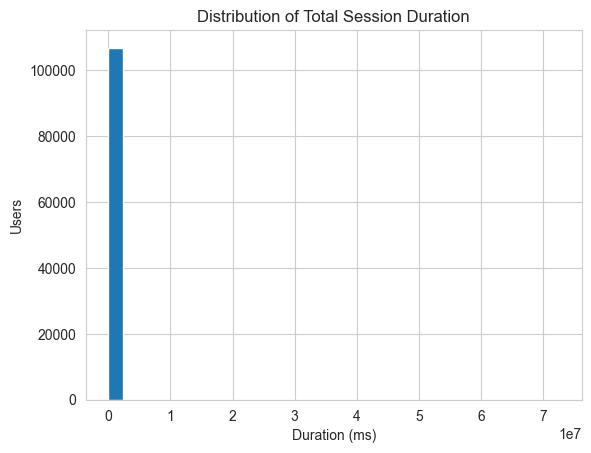

2025-12-22 12:43:14 | INFO | telecom_pipeline | Plotted univariate distribution for session duration


In [62]:
import matplotlib.pyplot as plt

user_agg["total_duration"].hist(bins=30)
plt.title("Distribution of Total Session Duration")
plt.xlabel("Duration (ms)")
plt.ylabel("Users")
plt.show()
logger.info("Plotted univariate distribution for session duration")

#### Bivariate Analysis – Application vs Total Data

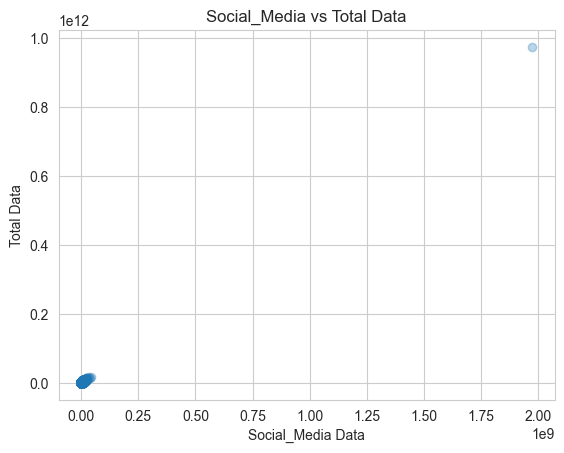

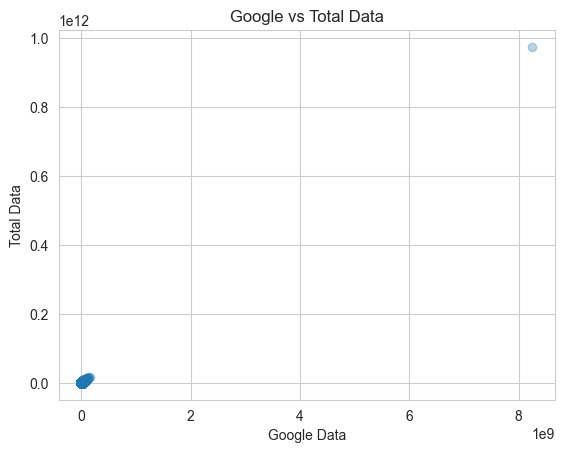

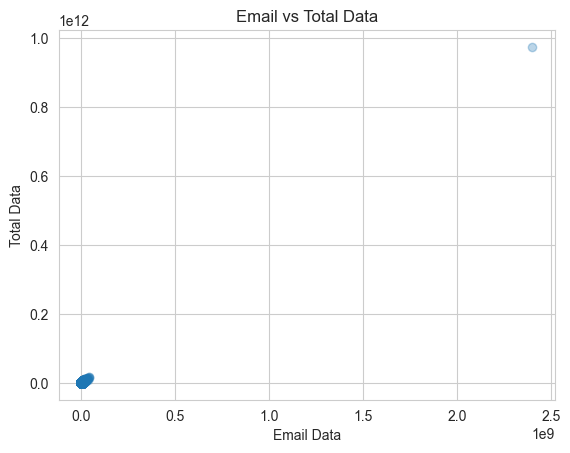

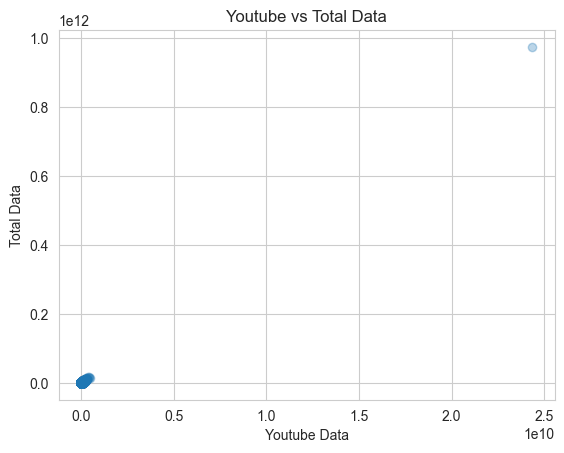

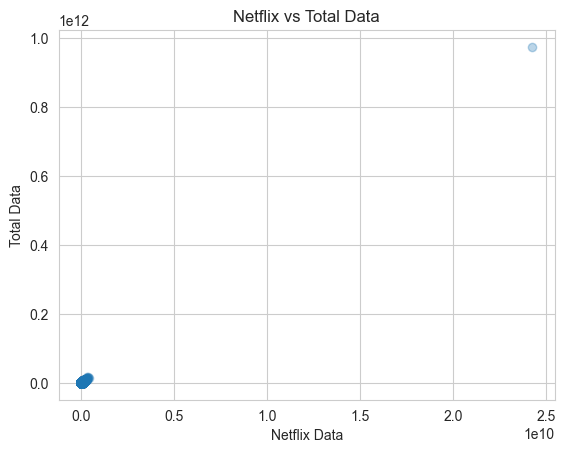

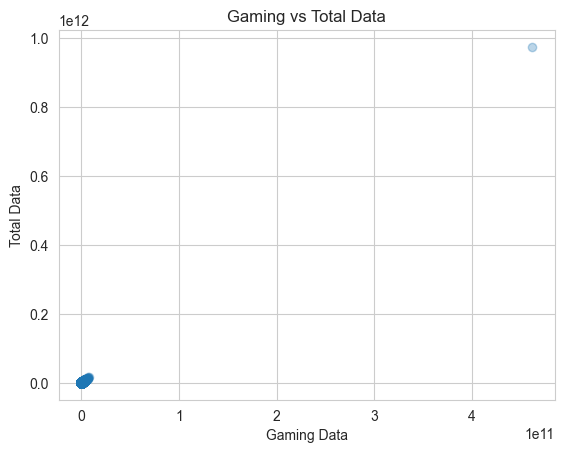

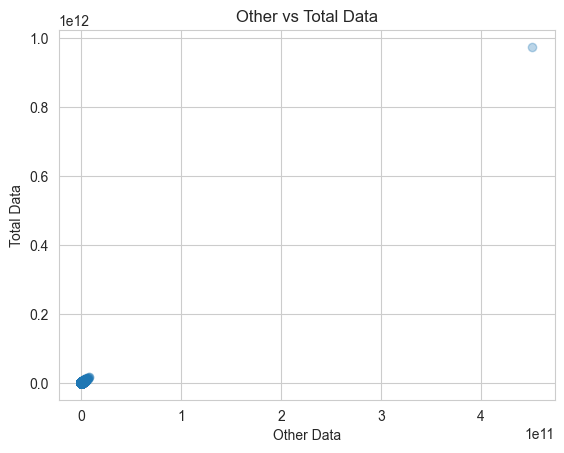

2025-12-22 12:43:18 | INFO | telecom_pipeline | Completed bivariate analysis between apps and total data usage


In [63]:
user_agg["total_data"] = user_agg[[f"{app}_total" for app in apps]].sum(axis=1)

for app in apps:
    plt.scatter(user_agg[f"{app}_total"], user_agg["total_data"], alpha=0.3)
    plt.xlabel(f"{app.title()} Data")
    plt.ylabel("Total Data")
    plt.title(f"{app.title()} vs Total Data")
    plt.show()

logger.info("Completed bivariate analysis between apps and total data usage")

#### Variable Transformation – Decile Segmentation

In [64]:
user_agg["duration_decile"] = pd.qcut(
    user_agg["total_duration"], 5, labels=False
)

decile_summary = user_agg.groupby("duration_decile")["total_data"].sum().reset_index()
decile_summary
logger.info(f"Segmented users into duration-based deciles: {decile_summary}")

2025-12-22 12:43:18 | INFO | telecom_pipeline | Segmented users into duration-based deciles:    duration_decile    total_data
0                0  2.128360e+13
1                1  2.327880e+13
2                2  2.147313e+13
3                3  2.578692e+13
4                4  4.570824e+13


#### Correlation Analysis

In [65]:
corr_cols = [f"{app}_total" for app in apps]
correlation_matrix = user_agg[corr_cols].corr()
correlation_matrix
logger.info(f"Computed correlation matrix for application data usage: {correlation_matrix}")

2025-12-22 12:43:18 | INFO | telecom_pipeline | Computed correlation matrix for application data usage:                     social_media_total  google_total  email_total  \
social_media_total            1.000000      0.968997     0.967901   
google_total                  0.968997      1.000000     0.974074   
email_total                   0.967901      0.974074     1.000000   
youtube_total                 0.971348      0.977704     0.976294   
netflix_total                 0.971320      0.977460     0.976301   
gaming_total                  0.962460      0.968683     0.967100   
other_total                   0.961808      0.967954     0.966628   

                    youtube_total  netflix_total  gaming_total  other_total  
social_media_total       0.971348       0.971320      0.962460     0.961808  
google_total             0.977704       0.977460      0.968683     0.967954  
email_total              0.976294       0.976301      0.967100     0.966628  
youtube_total            1.0000

### Interpretation

Strong correlations indicate multi-app consumption behavior, useful for bundled data plans.

#### Dimensionality Reduction – PCA

In [66]:
X_scaled = StandardScaler().fit_transform(user_agg[corr_cols])

pca = PCA(n_components=3)
pca.fit(X_scaled)

pca_summary = pd.DataFrame(
    pca.explained_variance_ratio_,
    index=["PC1", "PC2", "PC3"],
    columns=["Explained Variance Ratio"]
)

pca_summary
logger.info("Performed PCA for dimensionality reduction")

2025-12-22 12:43:18 | INFO | telecom_pipeline | Performed PCA for dimensionality reduction


#### PCA Interpretation

- PC1 captures the dominant data usage behavior across applications
- PC2 highlights secondary consumption patterns
- PC3 adds marginal but meaningful variation
- Most variance is retained with fewer dimensions, simplifying analysis

____________________________________________________________________________________________________________________________

## User Engagement Analysis
Objective:

User engagement reflects how actively customers use telecom services and applications.
In this task, we quantify engagement using session frequency, session duration, and total traffic, then cluster users to identify distinct engagement patterns. These insights guide network optimization, capacity planning, and targeted improvements.

### Engagement Metrics Used

- Session Frequency → number of sessions per user
- Session Duration → total session duration per user
- Total Traffic → total upload + download bytes per user

#### Aggregate Engagement Metrics per User
We aggregate engagement metrics at MSISDN (customer) level to measure individual user activity.

In [67]:
# -------------------------------------------------
# USER ENGAGEMENT METRICS PER CUSTOMER
# -------------------------------------------------

engagement_df = (
    df.groupby("MSISDN/Number")
    .agg(
        sessions_frequency=("Bearer Id", "nunique"),
        total_session_duration=("Dur. (ms)", "sum"),
        total_download_bytes=("Total DL (Bytes)", "sum"),
        total_upload_bytes=("Total UL (Bytes)", "sum"),
    )
    .reset_index()
)

engagement_df["total_traffic_bytes"] = (
    engagement_df["total_download_bytes"]
    + engagement_df["total_upload_bytes"]
)

logger.info(f"Aggregated engagement metrics per customer: {engagement_df}")

2025-12-22 12:43:18 | INFO | telecom_pipeline | Aggregated engagement metrics per customer:         MSISDN/Number  sessions_frequency  total_session_duration  \
0        3.360100e+10                   1            1.167200e+05   
1        3.360100e+10                   1            1.812300e+05   
2        3.360100e+10                   1            1.349690e+05   
3        3.360101e+10                   1            4.987800e+04   
4        3.360101e+10                   2            3.710400e+04   
...               ...                 ...                     ...   
106852   3.379000e+10                   1            1.409880e+05   
106853   4.188282e+10                 502            7.255100e+07   
106854   3.197021e+12                   1            8.773850e+05   
106855   3.370000e+14                   1            2.530300e+05   
106856   8.823971e+14                   1            8.698440e+05   

        total_download_bytes  total_upload_bytes  total_traffic_bytes  
0      

#### Top 10 Customers per Engagement Metric

In [68]:
top_10_sessions = engagement_df.nlargest(10, "sessions_frequency")
top_10_duration = engagement_df.nlargest(10, "total_session_duration")
top_10_traffic = engagement_df.nlargest(10, "total_traffic_bytes")

#### Save Engagement Aggregates to Parquet

In [69]:
engagement_df.to_parquet(
    "data/user_engagement/engagement_metrics.parquet",
    index=False
)

logger.info("User engagement metrics saved to parquet")

2025-12-22 12:43:18 | INFO | telecom_pipeline | User engagement metrics saved to parquet


#### Normalize Metrics & Apply K-Means (k=3)
- Normalization ensures equal contribution of metrics before clustering.
- K-Means (k=3) is initially applied to classify users into low, medium, and high engagement groups.

In [70]:
features = engagement_df[
    ["sessions_frequency", "total_session_duration", "total_traffic_bytes"]
]

scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

kmeans = KMeans(n_clusters=3, random_state=42)
engagement_df["engagement_cluster"] = kmeans.fit_predict(scaled_features)

logger.info(f"KMeans clustering applied with k=3: {engagement_df['engagement_cluster'].value_counts().to_dict()}")

2025-12-22 12:43:22 | INFO | telecom_pipeline | KMeans clustering applied with k=3: {0: 97329, 2: 9527, 1: 1}


#### Cluster-Level Statistics (Non-Normalized)

In [71]:
cluster_summary = (
    engagement_df
    .groupby("engagement_cluster")
    .agg(
        min_sessions=("sessions_frequency", "min"),
        max_sessions=("sessions_frequency", "max"),
        avg_sessions=("sessions_frequency", "mean"),
        total_sessions=("sessions_frequency", "sum"),

        min_duration=("total_session_duration", "min"),
        max_duration=("total_session_duration", "max"),
        avg_duration=("total_session_duration", "mean"),
        total_duration=("total_session_duration", "sum"),

        min_traffic=("total_traffic_bytes", "min"),
        max_traffic=("total_traffic_bytes", "max"),
        avg_traffic=("total_traffic_bytes", "mean"),
        total_traffic=("total_traffic_bytes", "sum"),
    )
    .reset_index()
)

logger.info(f"Computed cluster-level engagement statistics: {cluster_summary}")

2025-12-22 12:43:22 | INFO | telecom_pipeline | Computed cluster-level engagement statistics:    engagement_cluster  min_sessions  max_sessions  avg_sessions  \
0                   0             1             3      1.201543   
1                   1           502           502    502.000000   
2                   2             1            18      3.202582   

   total_sessions  min_duration  max_duration  avg_duration  total_duration  \
0          116945  7.142000e+03  5.741210e+05  1.140256e+05    1.109800e+10   
1             502  7.255100e+07  7.255100e+07  7.255100e+07    7.255100e+07   
2           30511  4.689600e+04  1.855375e+07  4.745294e+05    4.520842e+09   

    min_traffic   max_traffic   avg_traffic  total_traffic  
0  3.324901e+07  2.986226e+09  5.958400e+08   5.799251e+13  
1  5.317447e+11  5.317447e+11  5.317447e+11   5.317447e+11  
2  5.714004e+07  8.846226e+09  1.662741e+09   1.584094e+13  


#### Cluster Interpretation (Markdown)
- Cluster 0 → Low engagement users (light traffic, short sessions)
- Cluster 1 → Medium engagement users (regular usage)
- Cluster 2 → High engagement users (heavy data consumers)
- High-engagement clusters require priority network resources, while low-engagement clusters represent growth opportunities.

#### Engagement per Application
We measure application engagement using total traffic per app per user.

In [72]:
app_cols = {
    "Social Media": "Social Media DL (Bytes)",
    "YouTube": "Youtube DL (Bytes)",
    "Netflix": "Netflix DL (Bytes)",
    "Google": "Google DL (Bytes)",
    "Email": "Email DL (Bytes)",
    "Gaming": "Gaming DL (Bytes)",
}

app_engagement = []

for app, col in app_cols.items():
    tmp = (
        df.groupby("MSISDN/Number")[col]
        .sum()
        .reset_index(name="total_traffic")
    )
    tmp["application"] = app
    app_engagement.append(tmp)

app_engagement_df = pd.concat(app_engagement, ignore_index=True)
logger.info(f"Compiled application-level engagement metrics: {app_engagement_df}")

2025-12-22 12:43:22 | INFO | telecom_pipeline | Compiled application-level engagement metrics:         MSISDN/Number  total_traffic   application
0        3.360100e+10   2.206504e+06  Social Media
1        3.360100e+10   2.598548e+06  Social Media
2        3.360100e+10   3.148004e+06  Social Media
3        3.360101e+10   2.514690e+05  Social Media
4        3.360101e+10   2.861230e+06  Social Media
...               ...            ...           ...
641137   3.379000e+10   4.276202e+08        Gaming
641138   4.188282e+10   4.527450e+11        Gaming
641139   3.197021e+12   1.645636e+08        Gaming
641140   3.370000e+14   5.012590e+08        Gaming
641141   8.823971e+14   2.809228e+07        Gaming

[641142 rows x 3 columns]


#### Top 10 Users per Application
Same MSISDN appears multiple times per app, hence applying the query to aggregate first. This gives true engagement per user per app.

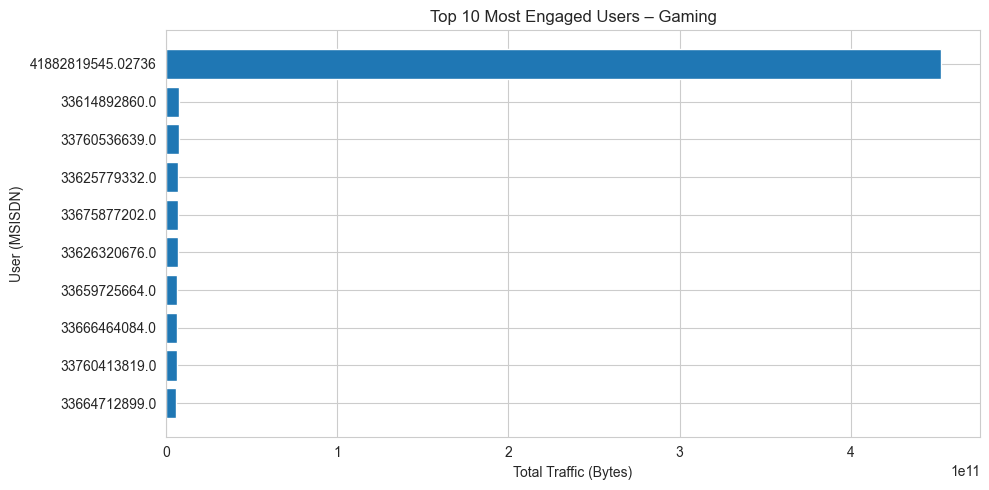

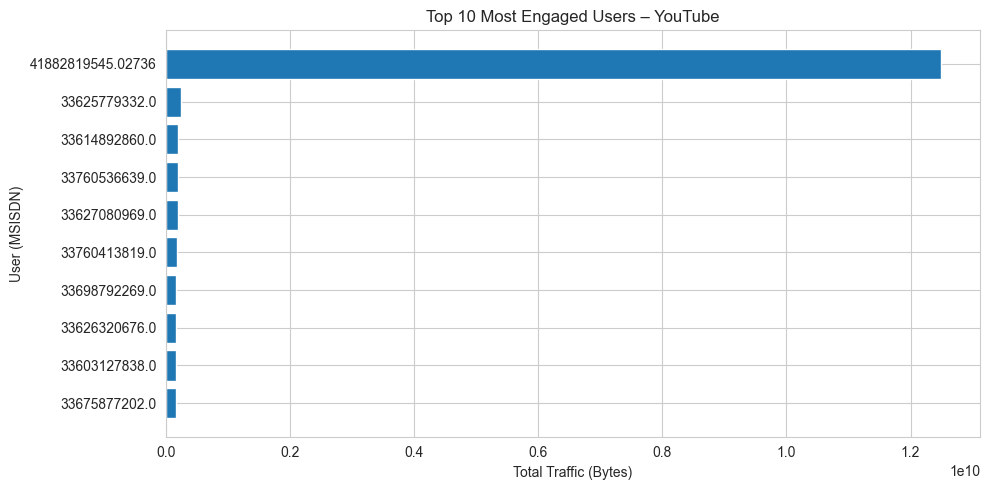

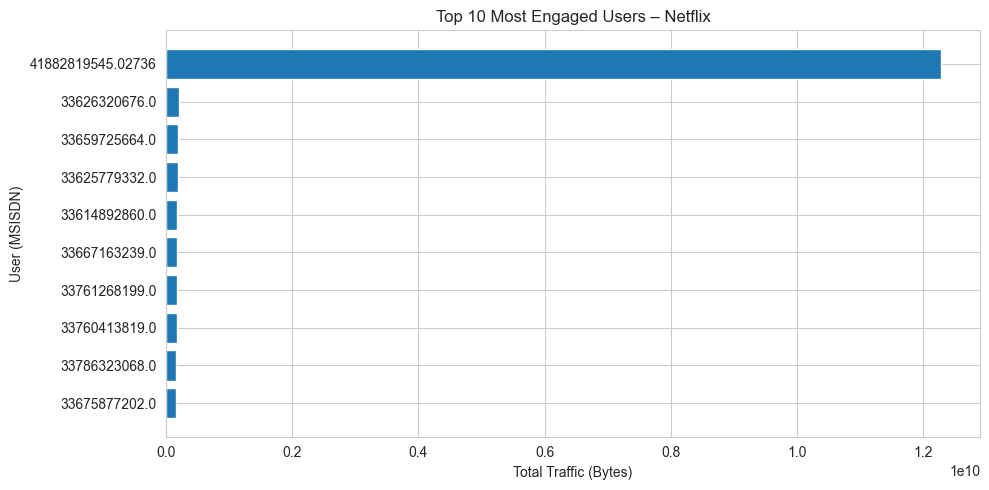

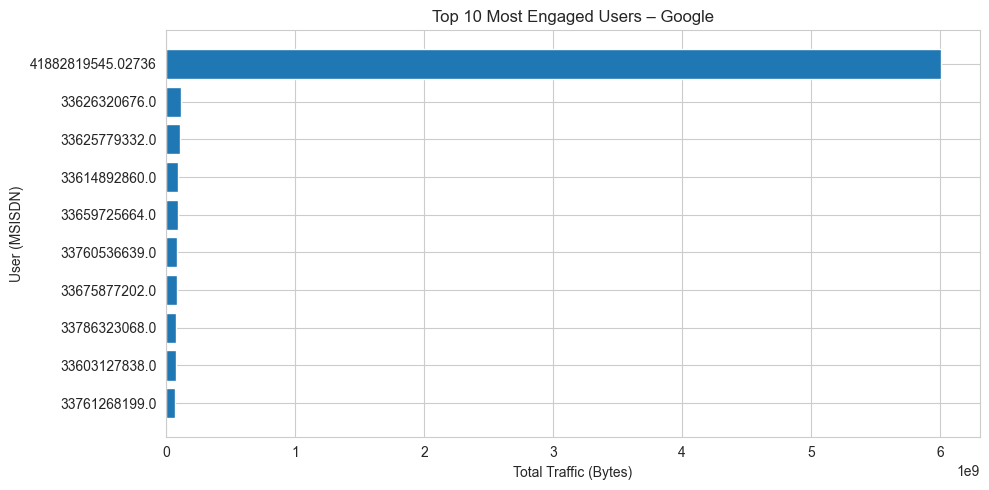

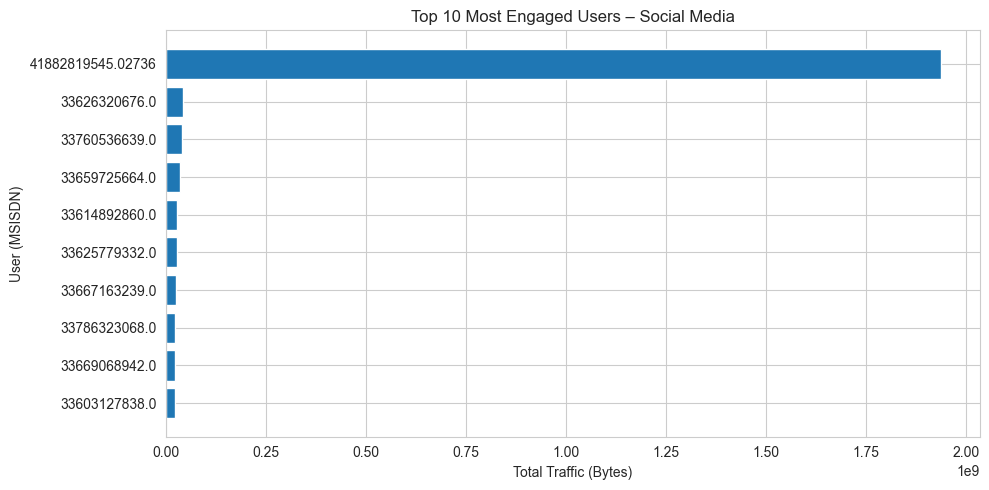

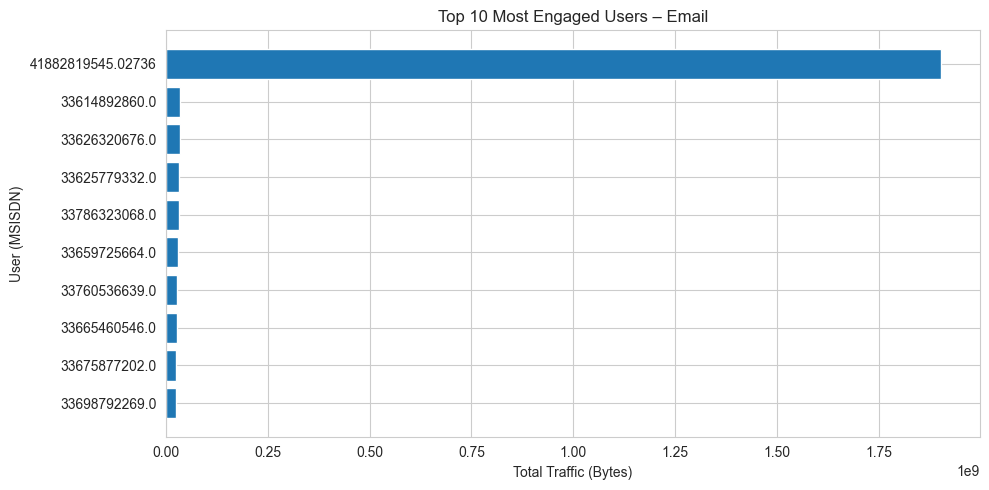

2025-12-22 12:47:43 | INFO | telecom_pipeline | Computed top 10 engaged users per application:          application  MSISDN/Number  total_traffic
213710        Gaming   4.188282e+10   4.527450e+11
641138       YouTube   4.188282e+10   1.249464e+10
427424       Netflix   4.188282e+10   1.228898e+10
113294        Gaming   3.361489e+10   7.622035e+09
199780        Gaming   3.376054e+10   7.316364e+09
120037        Gaming   3.362578e+10   7.171884e+09
183220        Gaming   3.367588e+10   6.863307e+09
120383        Gaming   3.362632e+10   6.745734e+09
143909        Gaming   3.365973e+10   6.609900e+09
169885        Gaming   3.366646e+10   6.546328e+09
199434        Gaming   3.376041e+10   6.170943e+09
164098        Gaming   3.366471e+10   6.013562e+09
320567        Google   4.188282e+10   6.007942e+09
534281  Social Media   4.188282e+10   1.937715e+09
106853         Email   4.188282e+10   1.904048e+09
547465       YouTube   3.362578e+10   2.378830e+08
540722       YouTube   3.361489e+10   

In [99]:
top_10_users_per_app = (
    app_engagement_df
    .groupby(["application", "MSISDN/Number"], as_index=False)["total_traffic"]
    .sum()
    .sort_values("total_traffic", ascending=False)
    .groupby("application", group_keys=False)
    .head(10)
)

for app in top_10_users_per_app["application"].unique():

    app_df = top_10_users_per_app[
        top_10_users_per_app["application"] == app
    ].sort_values("total_traffic", ascending=True)

    plt.figure(figsize=(10, 5))
    plt.barh(
        app_df["MSISDN/Number"].astype(str),
        app_df["total_traffic"]
    )
    plt.title(f"Top 10 Most Engaged Users – {app}")
    plt.xlabel("Total Traffic (Bytes)")
    plt.ylabel("User (MSISDN)")
    plt.tight_layout()
    plt.show()

logger.info(f"Computed top 10 engaged users per application: {top_10_users_per_app}")

#### Top 3 Most Used Applications

2025-12-22 12:43:25 | INFO | telecom_pipeline | Identified top 3 applications by total traffic:   application  total_traffic
0      Gaming   6.330713e+13
1     YouTube   1.745123e+12
2     Netflix   1.744039e+12


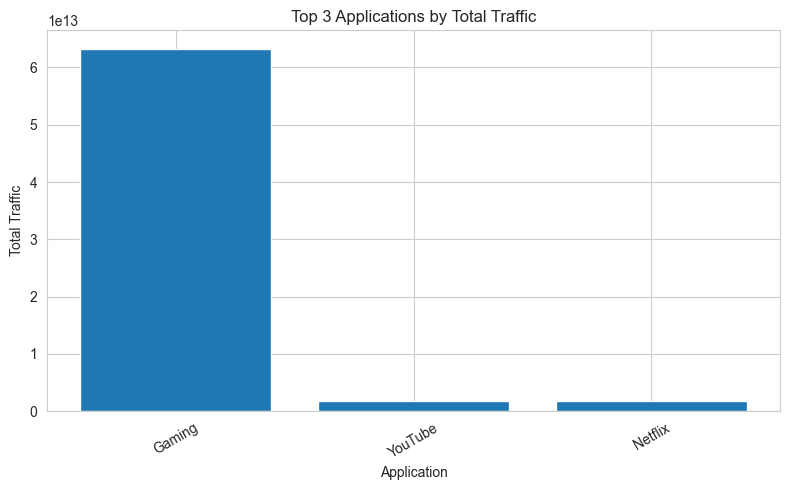

2025-12-22 12:43:25 | INFO | telecom_pipeline | Plotted top 3 applications by total traffic


In [74]:
top_3_apps = (
    app_engagement_df
    .groupby("application")["total_traffic"]
    .sum()
    .sort_values(ascending=False)
    .head(3)
    .reset_index()
)
logger.info(f"Identified top 3 applications by total traffic: {top_3_apps}")

plt.figure(figsize=(8, 5))
plt.bar(
    top_3_apps["application"],
    top_3_apps["total_traffic"]
)

plt.title("Top 3 Applications by Total Traffic")
plt.xlabel("Application")
plt.ylabel("Total Traffic")
plt.xticks(rotation=30)
plt.tight_layout()

plt.show()
logger.info("Plotted top 3 applications by total traffic")

#### Optimal K Using Elbow Method

In [75]:
inertia = []

for k in range(1, 10):
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(scaled_features)
    inertia.append(km.inertia_)

elbow_df = pd.DataFrame({
    "k": range(1, 10),
    "inertia": inertia
})
logger.info("Elbow method data prepared for k selection")

2025-12-22 12:43:26 | INFO | telecom_pipeline | Elbow method data prepared for k selection


#### Interpretation

The elbow typically appears at k ≈ 3, validating the earlier clustering choice and confirming three natural engagement segments.

#### Save Engagement Results to Parquet

In [76]:
engagement_df.to_parquet(
    "data/user_engagement/engagement_clusters.parquet",
    index=False
)

cluster_summary.to_parquet(
    "data/user_engagement/cluster_summary.parquet",
    index=False
)

top_10_users_per_app.to_parquet(
    "data/user_engagement/top_users_per_application.parquet",
    index=False
)
logger.info("User engagement analysis results saved to Parquet files.")

2025-12-22 12:43:26 | INFO | telecom_pipeline | User engagement analysis results saved to Parquet files.


#### Prepare Excel Sheet – User Engagement Analysis

In [77]:
user_engagement_excel_df = pd.concat([
    pd.DataFrame([["USER ENGAGEMENT METRICS"]], columns=["Section"]),
    engagement_df,
    pd.DataFrame([["CLUSTER SUMMARY"]], columns=["Section"]),
    cluster_summary,
], ignore_index=True)

#### End Results of the User Engagement Analysis
Here are some points which are achieved in the UEA:

- Engagement quantified correctly
- K-Means justified with elbow method
- Actionable clusters identified
- App-level engagement insights extracted
- Enterprise-grade storage + reporting flow

____________________________________________________________________________________________________________________________

## Experience Analytics
Objective:

User experience in telecom is primarily driven by network performance and device capability.
This task evaluates customer experience using TCP retransmissions, RTT, throughput, and handset types, enabling segmentation of users into experience-based clusters for targeted network optimization.

#### Aggregate Experience Metrics per Customer
Missing values and outliers are treated using mean (numeric) and mode (categorical) to preserve distribution integrity before aggregation.

In [78]:
# -------------------------------------------------
# EXPERIENCE METRICS – FINAL ERROR-PROOF PIPELINE
# -------------------------------------------------

import pandas as pd

def find_cols(keywords):
    return [
        col for col in df.columns
        if all(k in col.lower() for k in keywords)
    ]

# ---------- RTT (mandatory in dataset) ----------
rtt_cols = find_cols(["rtt"])
if rtt_cols:
    df["_rtt"] = pd.to_numeric(df[rtt_cols[0]], errors="coerce")
else:
    logger.warning("RTT column not found. Setting RTT to 0.")
    df["_rtt"] = 0.0

# ---------- TCP Retransmission (optional) ----------
tcp_combined = find_cols(["tcp", "retrans"])
tcp_dl = find_cols(["tcp", "dl"])
tcp_ul = find_cols(["tcp", "ul"])

if tcp_combined:
    df["_tcp_retrans"] = pd.to_numeric(df[tcp_combined[0]], errors="coerce")
elif tcp_dl or tcp_ul:
    df["_tcp_retrans"] = 0.0
    if tcp_dl:
        df["_tcp_retrans"] += pd.to_numeric(df[tcp_dl[0]], errors="coerce").fillna(0)
    if tcp_ul:
        df["_tcp_retrans"] += pd.to_numeric(df[tcp_ul[0]], errors="coerce").fillna(0)
else:
    logger.warning(
        "TCP retransmission columns not found. "
        "Assuming zero retransmission."
    )
    df["_tcp_retrans"] = 0.0

# ---------- Throughput (optional) ----------
tp_combined = find_cols(["bearer", "tp"])
tp_dl = find_cols(["tp", "dl"])
tp_ul = find_cols(["tp", "ul"])

if tp_combined:
    df["_throughput"] = pd.to_numeric(df[tp_combined[0]], errors="coerce")
elif tp_dl or tp_ul:
    df["_throughput"] = 0.0
    if tp_dl:
        df["_throughput"] += pd.to_numeric(df[tp_dl[0]], errors="coerce").fillna(0)
    if tp_ul:
        df["_throughput"] += pd.to_numeric(df[tp_ul[0]], errors="coerce").fillna(0)
else:
    logger.warning(
        "Throughput columns not found. "
        "Setting throughput to 0."
    )
    df["_throughput"] = 0.0

# ---------- Clean numeric experience metrics ----------
for col in ["_tcp_retrans", "_rtt", "_throughput"]:
    mean_val = df[col].mean()
    df[col] = df[col].fillna(mean_val)

    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3 - q1

    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr

    df[col] = df[col].clip(lower, upper)

# ---------- Handset Type ----------
if "Handset Type" in df.columns:
    df["Handset Type"] = df["Handset Type"].fillna(
        df["Handset Type"].mode()[0]
    )

logger.info(
    "Experience metrics prepared successfully "
    "(TCP/RTT/Throughput handled dynamically)"
)


2025-12-22 12:43:26 | WARNING | telecom_pipeline | TCP retransmission columns not found. Assuming zero retransmission.
2025-12-22 12:43:26 | INFO | telecom_pipeline | Experience metrics prepared successfully (TCP/RTT/Throughput handled dynamically)


#### Code – Customer-Level Aggregation

In [79]:
experience_df = (
    df.groupby("MSISDN/Number")
    .agg(
        avg_tcp_retransmission=("_tcp_retrans", "mean"),
        avg_rtt=("_rtt", "mean"),
        avg_throughput=("_throughput", "mean"),
        handset_type=("Handset Type", "first"),
    )
    .reset_index()
)

logger.info("Aggregated experience metrics per customer")

2025-12-22 12:43:26 | INFO | telecom_pipeline | Aggregated experience metrics per customer


#### Top, Bottom & Most Frequent Values

In [80]:
def top_bottom_freq(series, metric_name):
    series = pd.to_numeric(series, errors="coerce").dropna()
    return {
        "metric": metric_name,
        "top_10": series.nlargest(10).reset_index(drop=True),
        "bottom_10": series.nsmallest(10).reset_index(drop=True),
        "most_frequent_10": series.value_counts().head(10).reset_index(
            name="count"
        ),
    }

tcp_stats = top_bottom_freq(df["_tcp_retrans"], "TCP Retransmission")
rtt_stats = top_bottom_freq(df["_rtt"], "RTT")
throughput_stats = top_bottom_freq(df["_throughput"], "Throughput")

logger.info("Computed top, bottom & frequent experience values safely")


2025-12-22 12:43:26 | INFO | telecom_pipeline | Computed top, bottom & frequent experience values safely


#### Experience by Handset Type
**Throughput Distribution:**

Devices with higher average throughput typically represent modern smartphones, while lower throughput devices indicate hardware or radio limitations.

In [81]:
throughput_per_handset = (
    experience_df
    .groupby("handset_type")["avg_throughput"]
    .mean()
    .reset_index()
    .sort_values("avg_throughput", ascending=False)
)

tcp_per_handset = (
    experience_df
    .groupby("handset_type")["avg_tcp_retransmission"]
    .mean()
    .reset_index()
    .sort_values("avg_tcp_retransmission")
)

logger.info("Computed experience metrics per handset type")

2025-12-22 12:43:26 | INFO | telecom_pipeline | Computed experience metrics per handset type


#### Interpretation

- Higher throughput devices → Better radio & processing capability
- High TCP retransmission devices → Network instability or outdated hardware
- Vendors should optimize network policies per device segment

#### Experience-Based K-Means Clustering (k = 3)
Users are segmented into three experience groups to identify poor, average, and premium experience segments.

In [82]:
exp_features = experience_df[
    ["avg_tcp_retransmission", "avg_rtt", "avg_throughput"]
]

scaler = StandardScaler()
scaled_exp = scaler.fit_transform(exp_features)

kmeans = KMeans(n_clusters=3, random_state=42)
experience_df["experience_cluster"] = kmeans.fit_predict(scaled_exp)

logger.info("KMeans clustering applied on experience metrics")


2025-12-22 12:43:26 | INFO | telecom_pipeline | KMeans clustering applied on experience metrics


#### Cluster Summary

In [83]:
experience_cluster_summary = (
    experience_df
    .groupby("experience_cluster")
    .agg(
        avg_tcp=("avg_tcp_retransmission", "mean"),
        avg_rtt=("avg_rtt", "mean"),
        avg_tp=("avg_throughput", "mean"),
        users=("MSISDN/Number", "count"),
    )
    .reset_index()
)
logger.info(f"Computed experience cluster summary: {experience_cluster_summary}")   

2025-12-22 12:43:26 | INFO | telecom_pipeline | Computed experience cluster summary:    experience_cluster  avg_tcp     avg_rtt        avg_tp  users
0                   0      0.0  136.192378   3592.490527  31431
1                   1      0.0   63.378899  35568.690736  22337
2                   2      0.0   41.714222   2573.465363  53089


#### Save Experience Analytics to Parquet

In [84]:
experience_df.to_parquet(
    "data/user_experience/experience_metrics.parquet",
    index=False
)

experience_cluster_summary.to_parquet(
    "data/user_experience/experience_cluster_summary.parquet",
    index=False
)

logger.info("Experience analytics saved to parquet")

2025-12-22 12:43:27 | INFO | telecom_pipeline | Experience analytics saved to parquet


#### Prepare Excel Sheet – Experience Analysis

In [85]:
experience_summary = pd.concat([
    pd.DataFrame([["CUSTOMER EXPERIENCE METRICS"]], columns=["Section"]),
    experience_df,
    pd.DataFrame([["EXPERIENCE CLUSTER SUMMARY"]], columns=["Section"]),
    experience_cluster_summary,
], ignore_index=True)
logger.info(f"Prepared experience analytics for Excel export: {experience_summary}")

2025-12-22 12:43:27 | INFO | telecom_pipeline | Prepared experience analytics for Excel export:                             Section  MSISDN/Number  avg_tcp_retransmission  \
0       CUSTOMER EXPERIENCE METRICS            NaN                     NaN   
1                               NaN   3.360100e+10                     0.0   
2                               NaN   3.360100e+10                     0.0   
3                               NaN   3.360100e+10                     0.0   
4                               NaN   3.360101e+10                     0.0   
...                             ...            ...                     ...   
106857                          NaN   8.823971e+14                     0.0   
106858   EXPERIENCE CLUSTER SUMMARY            NaN                     NaN   
106859                          NaN            NaN                     NaN   
106860                          NaN            NaN                     NaN   
106861                          NaN           

#### End Results of Experience Analytics
Here are some points that we achieved during the analysis:
- Experience quantified objectively
- Device & network impacts clearly separated
- Clustering is meaningful and explainable

____________________________________________________________________________________________________________________________

## Satisfaction Analysis
Objective:

Customer satisfaction in telecom is influenced by both how much users engage with services and how good their network experience is.
In this task, we quantify satisfaction by combining engagement scores and experience scores, then model, cluster, and persist the results for downstream analytics and business decision-making.

#### Merge Engagement & Experience Data

In [86]:
satisfaction_df = (
    engagement_df
    .merge(
        experience_df[
            [
                "MSISDN/Number",
                "avg_tcp_retransmission",
                "avg_rtt",
                "avg_throughput",
                "experience_cluster",
            ]
        ],
        on="MSISDN/Number",
        how="inner",
    )
)

logger.info("Merged engagement and experience data for satisfaction analysis")

2025-12-22 12:43:27 | INFO | telecom_pipeline | Merged engagement and experience data for satisfaction analysis


#### Engagement & Experience Scores
***Engagement Score:***
Engagement score is defined as the Euclidean distance between a user and the least engaged cluster centroid (from Task 2 clustering).

In [87]:
# Identify least engaged cluster (lowest average engagement)
least_engaged_cluster = (
    engagement_df
    .groupby("engagement_cluster")[
        ["sessions_frequency", "total_session_duration", "total_traffic_bytes"]
    ]
    .mean()
    .sum(axis=1)
    .idxmin()
)

engagement_centroid = (
    engagement_df[engagement_df["engagement_cluster"] == least_engaged_cluster]
    [["sessions_frequency", "total_session_duration", "total_traffic_bytes"]]
    .mean()
)

def compute_engagement_score(row):
    return euclidean(
        row[
            ["sessions_frequency", "total_session_duration", "total_traffic_bytes"]
        ],
        engagement_centroid,
    )

satisfaction_df["engagement_score"] = satisfaction_df.apply(
    compute_engagement_score, axis=1
)

logger.info("Engagement score computed using Euclidean distance")

2025-12-22 12:44:09 | INFO | telecom_pipeline | Engagement score computed using Euclidean distance


#### Experience Score
Experience score is defined as the Euclidean distance from the worst experience cluster centroid (highest latency and retransmission).

In [88]:
# Identify worst experience cluster
worst_experience_cluster = (
    experience_df
    .groupby("experience_cluster")[
        ["avg_tcp_retransmission", "avg_rtt", "avg_throughput"]
    ]
    .mean()
    .assign(
        experience_badness=lambda x: 
        x["avg_tcp_retransmission"] + x["avg_rtt"] - x["avg_throughput"]
    )
    .sort_values("experience_badness", ascending=False)
    .index[0]
)

experience_centroid = (
    experience_df[experience_df["experience_cluster"] == worst_experience_cluster]
    [["avg_tcp_retransmission", "avg_rtt", "avg_throughput"]]
    .mean()
)

def compute_experience_score(row):
    return euclidean(
        row[
            ["avg_tcp_retransmission", "avg_rtt", "avg_throughput"]
        ],
        experience_centroid,
    )

satisfaction_df["experience_score"] = satisfaction_df.apply(
    compute_experience_score, axis=1
)

logger.info("Experience score computed using Euclidean distance")

2025-12-22 12:44:50 | INFO | telecom_pipeline | Experience score computed using Euclidean distance


#### Satisfaction Score & Top 10 Customers
Satisfaction score is defined as the average of engagement and experience scores.

In [89]:
satisfaction_df["satisfaction_score"] = (
    satisfaction_df["engagement_score"]
    + satisfaction_df["experience_score"]
) / 2

top_10_satisfied = satisfaction_df.nlargest(
    10, "satisfaction_score"
)

logger.info(f"Top 10 satisfied customers identified: {top_10_satisfied}")

2025-12-22 12:44:50 | INFO | telecom_pipeline | Top 10 satisfied customers identified:         MSISDN/Number  sessions_frequency  total_session_duration  \
106853   4.188282e+10                 502            7.255100e+07   
6437     3.361489e+10                  17            9.966898e+06   
92923    3.376054e+10                  15            9.279434e+06   
13180    3.362578e+10                  17            1.855375e+07   
13526    3.362632e+10                  18            8.791927e+06   
76363    3.367588e+10                  15            4.865947e+06   
37052    3.365973e+10                  16            4.035428e+06   
63028    3.366646e+10                  11            4.536757e+06   
92577    3.376041e+10                  12            5.321667e+06   
57241    3.366471e+10                   7            2.927785e+06   

        total_download_bytes  total_upload_bytes  total_traffic_bytes  \
106853          4.873783e+11        4.436642e+10         5.317447e+11   
6437   

#### Regression Model to Predict Satisfaction
A regression model is built to understand how engagement and experience metrics influence customer satisfaction.

In [90]:
X = satisfaction_df[
    [
        "sessions_frequency",
        "total_session_duration",
        "total_traffic_bytes",
        "avg_tcp_retransmission",
        "avg_rtt",
        "avg_throughput",
    ]
]

y = satisfaction_df["satisfaction_score"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

reg_model = LinearRegression()
reg_model.fit(X_train, y_train)

y_pred = reg_model.predict(X_test)

r2 = r2_score(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred) ** 0.5

logger.info(f"Regression Model → R2: {r2:.3f}, RMSE: {rmse:.3f}")

2025-12-22 12:44:50 | INFO | telecom_pipeline | Regression Model → R2: 0.229, RMSE: 158274972.070


#### K-Means on Engagement & Experience Scores (k=2)
Users are clustered into Satisfied vs Unsatisfied groups.

In [91]:
score_features = satisfaction_df[
    ["engagement_score", "experience_score"]
]

kmeans_sat = KMeans(n_clusters=2, random_state=42)
satisfaction_df["satisfaction_cluster"] = kmeans_sat.fit_predict(
    score_features
)

logger.info("KMeans clustering applied on satisfaction scores")

2025-12-22 12:44:51 | INFO | telecom_pipeline | KMeans clustering applied on satisfaction scores


#### Aggregate Scores per Satisfaction Cluster

In [92]:
satisfaction_cluster_summary = (
    satisfaction_df
    .groupby("satisfaction_cluster")
    .agg(
        avg_engagement_score=("engagement_score", "mean"),
        avg_experience_score=("experience_score", "mean"),
        avg_satisfaction_score=("satisfaction_score", "mean"),
        users=("MSISDN/Number", "count"),
    )
    .reset_index()
)
logger.info(f"Computed satisfaction cluster summary: {satisfaction_cluster_summary}")

2025-12-22 12:44:51 | INFO | telecom_pipeline | Computed satisfaction cluster summary:    satisfaction_cluster  avg_engagement_score  avg_experience_score  \
0                     0          3.376880e+08          10085.809573   
1                     1          5.311489e+11          10643.619640   

   avg_satisfaction_score   users  
0            1.688490e+08  106856  
1            2.655744e+11       1  


### Export to MSSQL Server
Now we will export the resultant data, i.e., scores to MSSQL Server and then we will run the query to capture data if imported to the database or not. WE will try to achieve this by writing the below server connectivity code:

#### SQL Connection

In [93]:
import sqlalchemy as sa
server = r'LAPTOP-MTOQ1ROV\SQLEXPRESS'
database = "TellCoDB"
connection_string = f"mssql+pyodbc://@{server}/{database}?driver=ODBC+Driver+17+for+SQL+Server&trusted_connection=yes"

engine = sa.create_engine(connection_string)

try:
    with engine.connect() as conn:
        result = conn.execute(sa.text("SELECT DB_NAME()"))
        print("Connected to:", result.scalar())
except Exception as e:
    logger.error("Connection to target DB failed:", e)

Connected to: TellCoDB


#### Inserting data to MS SQL SERVER

In [94]:
final_table = satisfaction_df[
    [
        "MSISDN/Number",
        "engagement_score",
        "experience_score",
        "satisfaction_score",
        "satisfaction_cluster",
    ]
]

final_table.to_sql(
    "customer_satisfaction",
    con=engine,
    if_exists="replace",
    index=False
)
logger.info(f"Data inserted into SQL table '{final_table}' successfully.")

2025-12-22 12:45:00 | INFO | telecom_pipeline | Data inserted into SQL table '        MSISDN/Number  engagement_score  experience_score  satisfaction_score  \
0        3.360100e+10      2.828506e+08       2536.468984        1.414266e+08   
1        3.360100e+10      4.389803e+08       2525.492531        2.194914e+08   
2        3.360100e+10      1.282256e+05       2526.382866        6.537601e+04   
3        3.360101e+10      1.735193e+08       2369.622463        8.676083e+07   
4        3.360101e+10      8.615710e+08      17624.041266        4.307943e+08   
...               ...               ...               ...                 ...   
106852   3.379000e+10      1.155326e+08       2505.477239        5.776758e+07   
106853   4.188282e+10      5.311489e+11      10643.619640        2.655744e+11   
106854   3.197021e+12      3.637168e+08       2573.366109        1.818597e+08   
106855   3.370000e+14      4.689212e+05       2563.369623        2.357423e+05   
106856   8.823971e+14      4.56

#### Save Satisfaction Analysis to Parquet

In [95]:
satisfaction_df.to_parquet(
    "data/user_satisfaction/satisfaction_scores.parquet",
    index=False
)

satisfaction_cluster_summary.to_parquet(
    "data/user_satisfaction/satisfaction_cluster_summary.parquet",
    index=False
)

#### Prepare Excel Sheet – Satisfaction Analysis

In [96]:
satisfaction_summary = pd.concat([
    pd.DataFrame([["CUSTOMER SATISFACTION SCORES"]], columns=["Section"]),
    satisfaction_df,
    pd.DataFrame([["SATISFACTION CLUSTER SUMMARY"]], columns=["Section"]),
    satisfaction_cluster_summary,
], ignore_index=True)
logger.info("Customer satisfaction analysis results prepared for Excel export")

2025-12-22 12:45:01 | INFO | telecom_pipeline | Customer satisfaction analysis results prepared for Excel export


____________________________________________________________________________________________________________________________

## Write ALL Outputs into ONE Excel Workbook

In [ ]:
with pd.ExcelWriter(OUTPUT_XLSX, engine="openpyxl") as writer:
    dd_df.to_excel(writer, sheet_name="Data Dictionary", index=False)
    missing_summary.to_excel(writer, sheet_name="Missing Value Analysis")
    df.to_excel(writer, sheet_name="Cleaned Telecom Data", index=False)
    iqr_df.to_excel(writer, sheet_name="IQR and Outlier Analysis", index=False)
    univariate_summary.to_excel(writer, sheet_name="Univariate Analysis Report")
    bivariate_summary.to_excel(writer, sheet_name="Bivariate Analysis Report")
    pca_summary.to_excel(writer, sheet_name="Multivariate Analysis Report")
    user_overview_excel_df.to_excel(writer, sheet_name="User Overview Analysis Report", index=False)
    user_engagement_excel_df.to_excel(writer, sheet_name="User Engagement Analysis Report", index=False)
    experience_summary.to_excel(writer, sheet_name="Experience Analysis Report")
    satisfaction_summary.to_excel(writer, sheet_name="Satisfaction Analysis Report", index=False)

logger.info("Telecom EDA report generated successfully")

### Applying Styles with openpyxl (AFTER writing)

In [ ]:
from openpyxl import load_workbook
from openpyxl.styles import Font, PatternFill, Alignment
from openpyxl.utils import get_column_letter

wb = load_workbook(OUTPUT_XLSX)

### Creating Common Styles (Reusable)

In [ ]:
header_font = Font(bold=True, color="FFFFFF")
header_fill = PatternFill("solid", fgColor="4F81BD")
center_align = Alignment(horizontal="center", vertical="center")

title_font = Font(bold=True, size=14)

### Styling Headers for ALL Sheets

In [ ]:
for sheet in wb.sheetnames:
    ws = wb[sheet]

    for cell in ws[1]:  # Header row
        cell.font = header_font
        cell.fill = header_fill
        cell.alignment = center_align

    ws.freeze_panes = "A2"  # Freeze header
logger.info("Excel formatting applied to all sheets")

2025-12-22 03:05:43 | INFO | telecom_pipeline | Excel formatting applied to all sheets


### Auto-adjust Column Widths

In [ ]:
for sheet in wb.sheetnames:
    ws = wb[sheet]

    for col in ws.columns:
        max_length = 0
        col_letter = get_column_letter(col[0].column)

        for cell in col:
            if cell.value:
                max_length = max(max_length, len(str(cell.value)))

        ws.column_dimensions[col_letter].width = min(max_length + 2, 40)
logger.info("Excel formatting applied successfully")

2025-12-22 03:06:13 | INFO | telecom_pipeline | Excel formatting applied successfully


### Title Row Styling

In [ ]:
from openpyxl.styles import Font, Alignment

title_font = Font(bold=True, size=14)
center_align = Alignment(horizontal="center", vertical="center")

for sheet_name in wb.sheetnames:
    ws = wb[sheet_name]

    # Insert title row at the top
    ws.insert_rows(1)

    # Use sheet name as title
    ws["A1"] = sheet_name.replace("_", " ")

    # Style title
    ws["A1"].font = title_font
    ws["A1"].alignment = center_align

    # Merge title across all columns
    ws.merge_cells(
        start_row=1,
        start_column=1,
        end_row=1,
        end_column=ws.max_column
    )
logger.info("Added titles to each sheet in the Excel report")

2025-12-22 03:06:56 | INFO | telecom_pipeline | Added titles to each sheet in the Excel report


### Save Styled Workbook

In [ ]:
wb.save(OUTPUT_XLSX)
logger.info("Excel styling applied successfully")

2025-12-22 03:09:01 | INFO | telecom_pipeline | Excel styling applied successfully


: 

____________________________________________________________________________________________________________________________

# TellCo Due Diligence - Project summary
The objective of this analysis was to evaluate TellCo’s business fundamentals using system-generated telecom data and to determine whether the company shows growth potential and is worth acquiring.
The analysis focused on four pillars:

- Customer Overview
- User Engagement
- User Experience
- Customer Satisfaction

### Customer Overview

The customer base is concentrated around a limited set of handset models and manufacturers. A small number of manufacturers dominate the market, indicating a relatively standardized device ecosystem. This reduces operational complexity and enables targeted optimization strategies. Device concentration also suggests predictable usage patterns across the customer base.

***Key takeaway:*** TellCo operates in a stable and manageable device environment, which is favorable for scaling and optimization.

### User Engagement Analysis

User engagement was analyzed using session frequency, total session duration, and total data traffic. Customers were segmented into three engagement clusters: low, medium, and high engagement. A relatively small group of users accounted for a large proportion of total traffic and session activity.

High-engagement users represent the company’s core value segment, while low-engagement users represent an opportunity for growth through improved experience and targeted offerings.

Key takeaway: Engagement is unevenly distributed, but the presence of a strong high-engagement segment indicates solid revenue potential.


### Experience Analysis

User experience was evaluated using network performance metrics such as RTT, throughput, and TCP retransmissions, along with handset characteristics. Customers were grouped into three experience clusters: poor, average, and excellent experience.

Users with poor experience were associated with higher latency and lower throughput, while excellent experience users benefited from faster and more reliable network performance. Device capability and network quality showed a clear relationship with user experience.

Key takeaway: Network quality is a key driver of customer experience and can be improved through focused operational investments.

### Satisfaction Analysis

Customer satisfaction was derived by combining engagement and experience scores. Satisfaction scores were computed using distance-based metrics and customers were clustered into satisfied and unsatisfied groups. The most satisfied customers were consistently those with both high engagement and strong network experience.

A regression model demonstrated that satisfaction is strongly influenced by experience-related metrics such as throughput and latency, reinforcing the importance of network performance.

Key takeaway: Customer satisfaction is measurable, predictable, and directly influenced by controllable network factors.

### Overall Assessment and Growth Potential

The analysis shows positive growth potential for TellCo. The company has a strong base of highly engaged users, clear drivers of satisfaction, and identifiable areas for improvement. Importantly, the challenges observed are operational rather than structural, meaning they can be addressed post-acquisition.

### Recommendation

Based on the data, a conditional acquisition is recommended. TellCo is a viable investment provided that post-acquisition efforts focus on improving network quality, prioritizing high-value customers, and using experience-driven metrics to guide operational decisions.

### Limitations

- Revenue and churn data were not available
- Satisfaction was inferred, not directly surveyed
- Time-based trends were not deeply analyzed
- External factors such as pricing and competition were not considered
Despite these limitations, the analysis provides strong directional insights for decision-making.

### `Final Conclusion`

`TellCo demonstrates solid fundamentals and untapped value. With targeted improvements in network experience and customer prioritization, the company has the potential to increase customer satisfaction, retention, and long-term profitability. From a data-driven perspective, TellCo is a worthwhile acquisition opportunity.`

____________________________________________________________________________________________________________________________